DATA SCIENCE MINI-PROJECT: DATA FROM ELECTRIC ARC FURNACE.

By Joaquin Velarde, a24joave.  20010425-T533

We took the data from an Electric Arc Furnace. The dataset can be found here: 
https://www.kaggle.com/datasets/yuriykatser/industrial-data-from-the-arc-furnace

In our dataset there is a lot of information regarding the processing of around 20000 heats of metal. We chose to analyze how well one can predict the oxidation levels of a heat just from the starting material composition. In a more thorough analysis, maybe more information can be taken into account for predicting oxidation levels, or even other important features, such as temperature or energy usage. 

In [257]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split


some functions we will use:

In [258]:
def see_duplicates(df):
    df_duplicates=df[df.duplicated(keep=False)]
    print("number of rows =", len(df)) 
    print("number of duplicated rows =", len(df_duplicates))
    print(df_duplicates) 

def find_outliers_IQR(df,c):
    print(len(df))
    q1=df[c].quantile(0.25)
    q3=df[c].quantile(0.75)
    IQR=q3-q1
    print(IQR)
    outliers=df[c][((df[c]<(q1-1.5*IQR)) | (df[c]>(q3+1.5*IQR)) )]
    print(f"Number of outliers for {c}: {len(outliers)}")
    print(f"Max outlier: {outliers.max()}")
    print(f"Min outlier: {outliers.min()}")
    return outliers.index.tolist()

def number_outliers_IQR(df,c):
    print(len(df))
    q1=df[c].quantile(0.25)
    q3=df[c].quantile(0.75)
    IQR=q3-q1
    print(IQR)
    outliers=df[c][((df[c]<(q1-1.5*IQR)) | (df[c]>(q3+1.5*IQR)) )]
    print(f"Number of outliers for {c}: {len(outliers)}")
    print(f"Max outlier: {outliers.max()}")
    print(f"Min outlier: {outliers.min()}")



First, we preprocess the data.

In [259]:
df_temp=pd.read_csv('eaf_temp.csv', sep=',')

print(df_temp)



       HEATID             DATETIME    TEMP  VALO2_PPM
0      6F0020  2016-01-01 19:15:00  1650.0     1242.0
1      6F0021  2016-01-01 20:05:00  1649.0     1160.0
2      6F0021  2016-01-01 20:05:00  1649.0     1160.0
3      6F0021  2016-01-01 20:03:00  1606.0     1152.0
4      6F0022  2016-01-01 21:03:00  1636.0      947.0
...       ...                  ...     ...        ...
85099  5F8441  2015-12-31 21:53:00  1653.0        0.0
85100  5F8441  2015-12-31 21:54:00  1650.0     1133.0
85101  5F8441  2015-12-31 21:52:00  1603.0        0.0
85102  5F8442  2015-12-31 22:38:00  1667.0     1253.0
85103  5F8442  2015-12-31 22:37:00  1633.0        0.0

[85104 rows x 4 columns]


In [260]:
see_duplicates(df_temp)

number of rows = 85104
number of duplicated rows = 3520
       HEATID             DATETIME    TEMP  VALO2_PPM
1      6F0021  2016-01-01 20:05:00  1649.0     1160.0
2      6F0021  2016-01-01 20:05:00  1649.0     1160.0
20     6F0028  2016-01-02 03:25:00  1651.0     1048.0
21     6F0028  2016-01-02 03:25:00  1651.0     1048.0
94     6F0053  2016-01-03 00:27:00  1500.0       17.0
...       ...                  ...     ...        ...
84966  5F8403  2015-12-30 01:53:00  1621.0      845.0
85036  5F8427  2015-12-31 00:53:00  1663.0        0.0
85037  5F8427  2015-12-31 00:53:00  1663.0        0.0
85045  5F8429  2015-12-31 03:51:00  1574.0        0.0
85046  5F8429  2015-12-31 03:51:00  1574.0        0.0

[3520 rows x 4 columns]


We drop duplicates.

In [261]:
df_no_dup=df_temp.copy()
df_no_dup.drop_duplicates(inplace=True)
df_no_dup.reset_index(drop=True)


HEATID             DATETIME    TEMP  VALO2_PPM
0      6F0020  2016-01-01 19:15:00  1650.0     1242.0
1      6F0021  2016-01-01 20:05:00  1649.0     1160.0
2      6F0021  2016-01-01 20:03:00  1606.0     1152.0
3      6F0022  2016-01-01 21:03:00  1636.0      947.0
4      6F0022  2016-01-01 21:02:00  1620.0      943.0
...       ...                  ...     ...        ...
83291  5F8441  2015-12-31 21:53:00  1653.0        0.0
83292  5F8441  2015-12-31 21:54:00  1650.0     1133.0
83293  5F8441  2015-12-31 21:52:00  1603.0        0.0
83294  5F8442  2015-12-31 22:38:00  1667.0     1253.0
83295  5F8442  2015-12-31 22:37:00  1633.0        0.0

[83296 rows x 4 columns]

We drop the null oxidation values. These are heats that were not measured correctly.

In [262]:
df_oxidation=df_no_dup.loc[df_no_dup['VALO2_PPM'] != 0]
df_oxidation.describe()

TEMP     VALO2_PPM
count  73344.000000  73344.000000
mean    1634.532313   1012.990746
std       26.768583   1308.124360
min     1115.000000      1.000000
25%     1618.000000    678.000000
50%     1637.000000    842.000000
75%     1652.000000   1020.000000
max     1850.000000   9999.000000

We take only the last oxidation value of each heat, since it is the one taken right before tapping. 

In [263]:
df_dates=df_oxidation.copy()
df_dates['DATETIME'] = pd.to_datetime(df_oxidation['DATETIME'])

df_true_ox = df_dates.sort_values(by=['HEATID', 'DATETIME', 'VALO2_PPM'], ascending=[True, False, False])
df_true_ox.drop_duplicates(subset='HEATID', keep='first',inplace=True)

print(df_true_ox.describe())

                            DATETIME          TEMP     VALO2_PPM
count                          20667  20667.000000  20667.000000
mean   2016-07-17 21:39:36.452315648   1649.956017    907.010403
min              2015-01-01 01:32:00   1499.000000      1.000000
25%              2015-09-15 10:09:30   1641.000000    756.000000
50%              2016-06-05 01:09:00   1650.000000    881.000000
75%              2017-02-17 23:59:30   1658.000000   1024.000000
max              2018-07-29 09:16:00   1850.000000   9999.000000
std                              NaN     13.984723    409.193341


Now we look at oxidation outliers. 

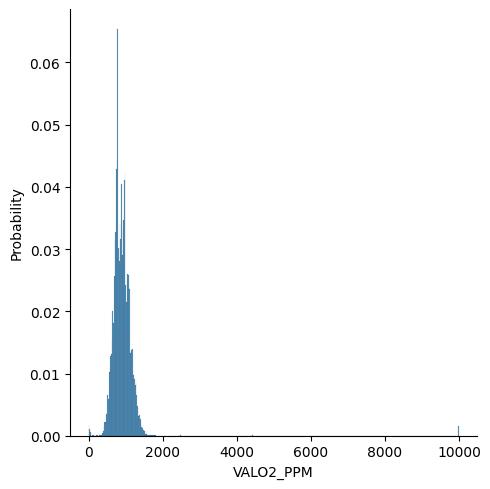

In [264]:
sns.displot(df_true_ox,x="VALO2_PPM",stat='probability')

In [265]:
outliers_index=find_outliers_IQR(df_true_ox, "VALO2_PPM")

print(outliers_index)


20667
268.0
Number of outliers for VALO2_PPM: 273
Max outlier: 9999.0
Min outlier: 1.0
[60789, 61007, 61208, 61218, 61469, 61512, 61861, 61875, 62307, 62543, 62782, 62829, 63033, 63313, 63651, 64194, 64846, 64960, 65332, 66131, 66310, 66811, 66890, 66946, 67146, 67358, 67405, 68229, 68283, 68288, 68310, 68997, 69257, 69857, 69868, 70373, 70415, 70634, 70745, 71136, 71255, 71376, 71394, 71617, 72025, 73214, 73564, 73996, 74070, 74506, 75005, 75536, 75810, 76068, 76365, 76597, 76601, 76727, 76793, 76856, 76896, 76914, 77131, 77225, 77332, 77476, 78337, 78344, 78694, 78783, 79071, 79216, 79231, 79323, 79334, 79335, 79589, 79594, 79935, 79989, 80062, 80067, 80080, 80095, 80098, 80191, 80271, 80289, 80304, 80337, 80400, 80406, 80421, 80484, 80499, 80503, 80509, 80514, 80526, 80655, 80678, 80707, 80718, 80720, 80760, 80776, 80950, 80991, 80996, 81062, 81138, 81207, 81214, 81262, 81531, 81534, 81539, 81969, 82004, 82038, 82053, 82335, 82364, 82417, 82444, 82504, 82621, 82637, 83114, 83139, 83

Most of the outliers seem to be mistakes in measuring, and, since there is not a lot of them, we drop them. 

In [266]:
df_cleaned=df_true_ox.drop(outliers_index)

df_cleaned.describe()

DATETIME          TEMP     VALO2_PPM
count                          20394  20394.000000  20394.000000
mean   2016-07-20 09:27:28.531920896   1649.910366    891.869619
min              2015-01-01 01:32:00   1555.000000    354.000000
25%              2015-09-15 09:47:15   1641.000000    756.000000
50%              2016-06-09 20:13:00   1650.000000    880.000000
75%              2017-02-20 20:31:45   1658.000000   1019.000000
max              2018-07-29 09:16:00   1716.000000   1426.000000
std                              NaN     13.531807    192.576590

Now we look at the shape of our cleaned oxidation data. 

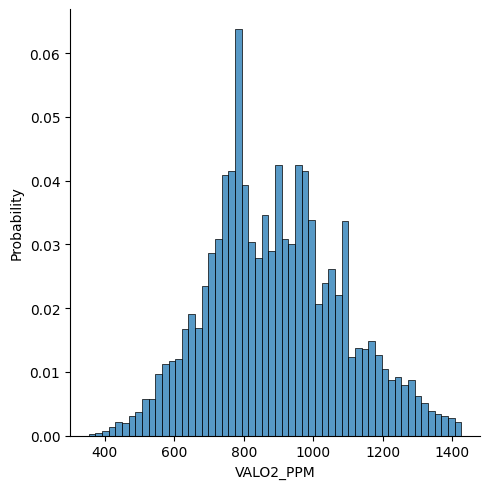

In [267]:
sns.displot(df_cleaned,x="VALO2_PPM",stat='probability')

Now that we have cleaned the oxidation values, we need something to predict oxidation values with. We will start by questioning how initial chemical composition of our metal can affect the oxidation levels of the tapped product. This question is only one among dozens that can be answered with our dataset. It seemed like a good starting point. 

In [268]:
df_chem=pd.read_csv('lf_initial_chemical_measurements.csv', sep=',')

In [269]:
print(df_chem)

       HEATID  POSITIONROW             DATETIME    VALC   VALSI   VALMN  \
0      6F0020            1  2016-01-01 19:59:00  0,2312  0,2449  1,2652   
1      6F0021            1  2016-01-01 20:59:00  0,2507  0,2687  1,2916   
2      6F0022            1  2016-01-01 21:53:00   0,234  0,2276  1,1963   
3      6F0023            1  2016-01-01 23:27:00  0,3652  0,2154  0,7934   
4      6F0024            1  2016-01-02 00:32:00   0,374  0,1932  0,7948   
...       ...          ...                  ...     ...     ...     ...   
20822  5F8438            1  2015-12-31 20:09:00  0,1713  0,1593  0,4194   
20823  5F8439            1  2015-12-31 20:38:00  0,1812  0,1928  0,3834   
20824  5F8440            1  2015-12-31 21:29:00  0,1752  0,2399  0,3864   
20825  5F8441            1  2015-12-31 22:20:00  0,1736   0,218  0,3644   
20826  5F8442            1  2015-12-31 23:04:00  0,1828   0,232  0,4115   

         VALP    VALS   VALCU   VALCR   VALMO   VALNI  
0      0,0076  0,0147  0,2072  0,0726  0,01

We check for duplicates and null values. 

In [270]:
df_chem.drop_duplicates(inplace=True)
print(df_chem.isnull().sum())

HEATID         0
POSITIONROW    0
DATETIME       0
VALC           0
VALSI          0
VALMN          0
VALP           0
VALS           0
VALCU          0
VALCR          0
VALMO          0
VALNI          0
dtype: int64


Now we merge both dataframes with the information we are going to use. 

In [271]:
df_chem2 = df_chem.drop(columns=['DATETIME', 'POSITIONROW'])

df_merged = df_cleaned.merge(df_chem2, on='HEATID', how='inner')

df_merged.drop(columns=['DATETIME', 'TEMP'], inplace=True)

print(df_merged)

       HEATID  VALO2_PPM    VALC   VALSI   VALMN    VALP    VALS   VALCU  \
0      5F0002      403.0  0,1457   0,276  0,5306  0,1457  0,0167  0,1998   
1      5F0003      698.0  0,1359  0,2898  0,5285  0,1359  0,0048  0,1897   
2      5F0004      700.0  0,2183  0,3296  1,1203  0,2183  0,0273  0,2372   
3      5F0005      669.0  0,1436  0,2701  0,5227  0,1436  0,0092  0,1948   
4      5F0006      789.0  0,2368  0,2227  1,3179  0,2368  0,0165  0,2437   
...       ...        ...     ...     ...     ...     ...     ...     ...   
20389  8F5227      641.0  0,1122  0,0914  0,4283  0,0076  0,0322  0,1949   
20390  8F5392      611.0  0,1626  0,1577  0,6952  0,0101  0,0074  0,1891   
20391  8F5471     1073.0  0,1059  0,0643  0,4618  0,0088  0,0149  0,1367   
20392  8F5472      955.0   0,144  0,1991  0,4518  0,0072   0,003   0,139   
20393  8F5473      947.0  0,1239   0,182  0,4102  0,0076  0,0063  0,1026   

        VALCR   VALMO   VALNI  
0       0,524   0,276  0,1201  
1      0,5159  0,2898  

We are not interested in the HEATID anymore.

In [272]:
df_final=df_merged.drop(columns=['HEATID'])
print(df_final.dtypes)



VALO2_PPM    float64
VALC          object
VALSI         object
VALMN         object
VALP          object
VALS          object
VALCU         object
VALCR         object
VALMO         object
VALNI         object
dtype: object


All the material values are of type object, we need to change them to float

In [273]:
df_final1 = df_final.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtypes == "object" else col)

print(df_final1.dtypes)
print(df_final1)

VALO2_PPM    float64
VALC         float64
VALSI        float64
VALMN        float64
VALP         float64
VALS         float64
VALCU        float64
VALCR        float64
VALMO        float64
VALNI        float64
dtype: object
       VALO2_PPM    VALC   VALSI   VALMN    VALP    VALS   VALCU   VALCR  \
0          403.0  0.1457  0.2760  0.5306  0.1457  0.0167  0.1998  0.5240   
1          698.0  0.1359  0.2898  0.5285  0.1359  0.0048  0.1897  0.5159   
2          700.0  0.2183  0.3296  1.1203  0.2183  0.0273  0.2372  0.0942   
3          669.0  0.1436  0.2701  0.5227  0.1436  0.0092  0.1948  0.4835   
4          789.0  0.2368  0.2227  1.3179  0.2368  0.0165  0.2437  0.0839   
...          ...     ...     ...     ...     ...     ...     ...     ...   
20389      641.0  0.1122  0.0914  0.4283  0.0076  0.0322  0.1949  0.7945   
20390      611.0  0.1626  0.1577  0.6952  0.0101  0.0074  0.1891  0.0912   
20391     1073.0  0.1059  0.0643  0.4618  0.0088  0.0149  0.1367  0.4242   
20392      955.0

Now we analyze the distributions of the metals in our heats. 

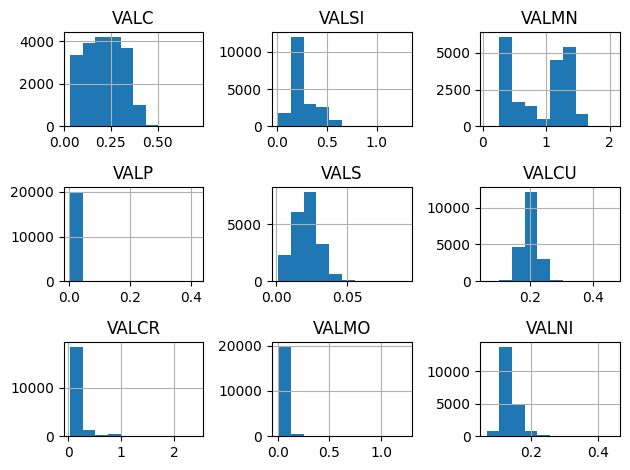

In [274]:
X=df_final1.drop(columns=['VALO2_PPM'])
histograms=X.hist()
histograms
plt.tight_layout()
plt.show()

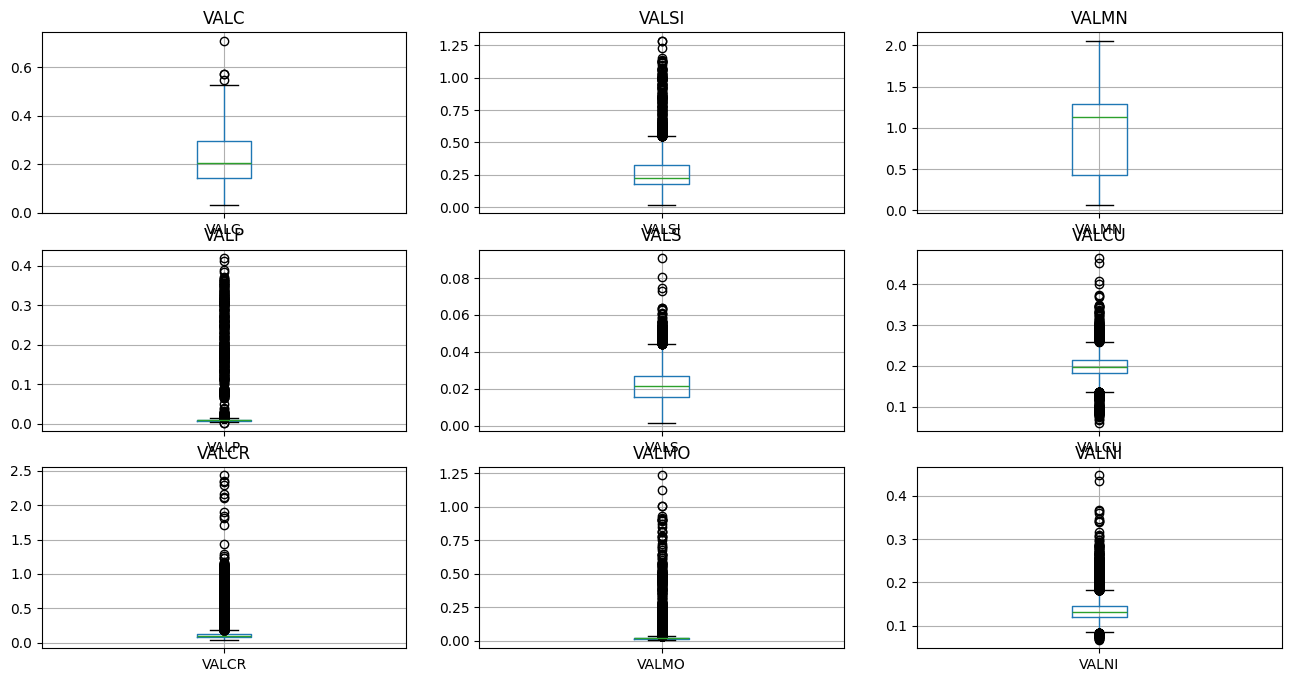

In [275]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))  
axes = axes.flatten()  

for i, col in enumerate(X.columns):
    X.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)


There seem to be a lot of outliers. 

In [276]:
outliers_index = {}
for column in X.columns:
    q1=X[column].quantile(0.25)
    q3=X[column].quantile(0.75)
    IQR=q3-q1
    print(f"IQR for column {column}: {IQR} {(q1-1.5*IQR,q3+1.5*IQR)}")
    outliers=X[column][((X[column]<(q1-1.5*IQR)) | (X[column]>(q3+1.5*IQR)) )]
    outliers_index[column] = outliers
    print(f"Number of outliers for {column}: {len(outliers)}")
    print(f"Max outlier for {column}: {outliers.max()}")
    print(f"Min outlier for {column}: {outliers.min()}")
    print(outliers)

IQR for column VALC: 0.15429999999999996 (np.float64(-0.08814999999999992), np.float64(0.5290499999999999))
Number of outliers for VALC: 4
Max outlier for VALC: 0.7114
Min outlier for VALC: 0.5476
11677    0.7114
19768    0.5736
19769    0.5476
20063    0.5725
Name: VALC, dtype: float64
IQR for column VALSI: 0.1484 (np.float64(-0.04230000000000003), np.float64(0.5513))
Number of outliers for VALSI: 598
Max outlier for VALSI: 1.2883
Min outlier for VALSI: 0.5515
37       0.5674
38       0.5780
66       0.6454
85       0.5526
87       0.5767
          ...  
20204    0.5531
20252    0.5575
20293    0.5791
20313    0.6606
20315    0.6665
Name: VALSI, Length: 598, dtype: float64
IQR for column VALMN: 0.8608 (np.float64(-0.8600999999999999), np.float64(2.5831))
Number of outliers for VALMN: 0
Max outlier for VALMN: nan
Min outlier for VALMN: nan
Series([], Name: VALMN, dtype: float64)
IQR for column VALP: 0.0026999999999999993 (np.float64(0.002850000000000001), np.float64(0.01364999999999999

Okay, we have a lot of outliers here, maybe we can see what distribution they follow. If a good percentage of the outliers has bad oxidation results, we might have found something. 

To make matters a bit easier, we are going to make our problem a classification task. We will divide the PPM values in 'acceptable' and 'not acceptable'. Consulting with experts we came to the conclusion that PPM values above 1000 ppm of oxygen when tapping can be worrying. 

In [277]:
df_final1["OX_category"] = (df_final1["VALO2_PPM"] > 1000).astype(int)


Okay, now the distribution of bad and good oxygen levels in our dataset is as follows:

Category value counts:
OX_category
0    14886
1     5508
Name: count, dtype: int64


C:\Users\quinito\AppData\Local\Temp\ipykernel_21280\139008999.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final1, x="OX_category", palette="Set2")


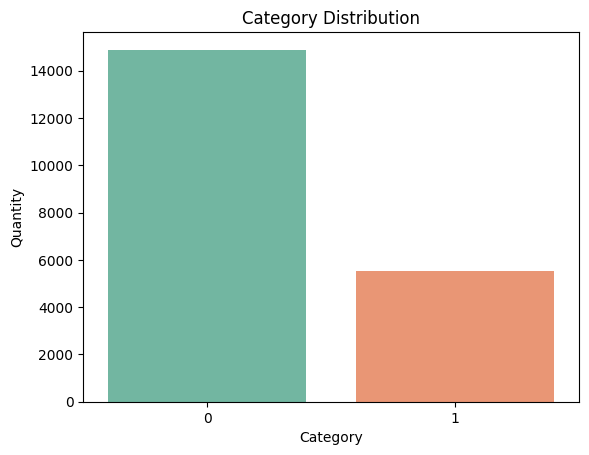

In [278]:
print("Category value counts:")
print(df_final1["OX_category"].value_counts())


sns.countplot(data=df_final1, x="OX_category", palette="Set2")

plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Quantity")
plt.show()

This is, about a 3:1 proportion between good and bad results in oxygen levels in our dataset. 

Now let's see how the outliers relate to having bad levels of oxygen. 


VALSI value counts:
OX_category
1    398
0    200
Name: count, dtype: int64


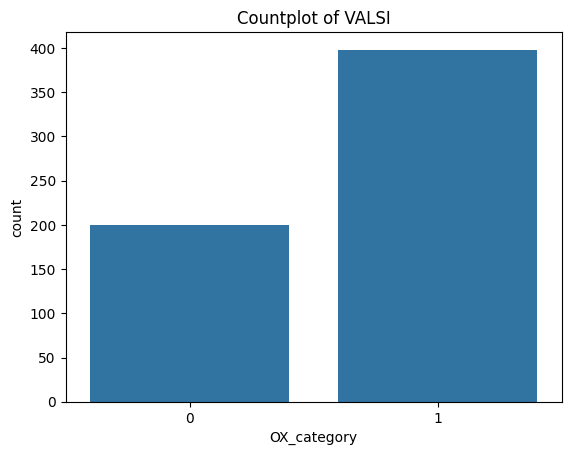


VALNI value counts:
OX_category
0    677
1    294
Name: count, dtype: int64


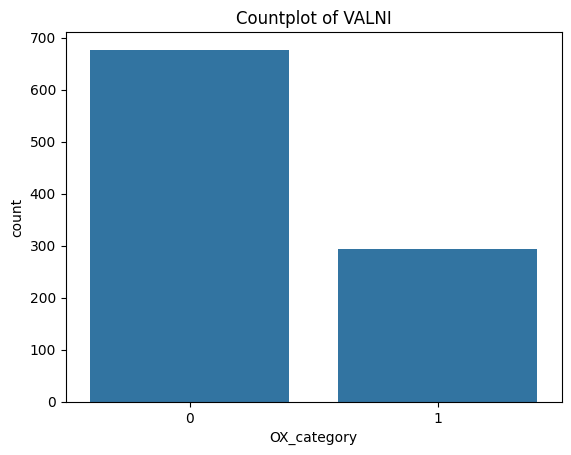


VALMO value counts:
OX_category
0    1171
1     354
Name: count, dtype: int64


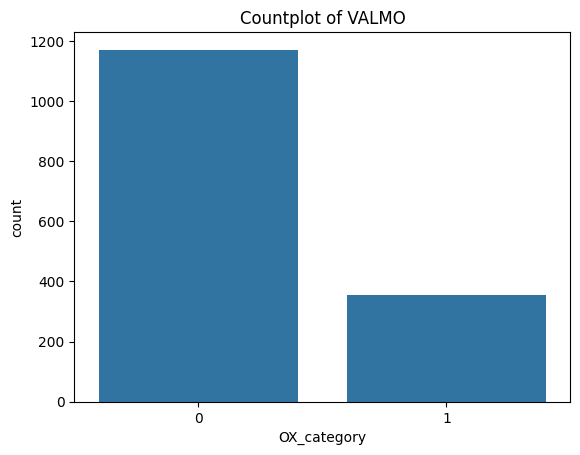


VALCR value counts:
OX_category
0    1627
1     574
Name: count, dtype: int64


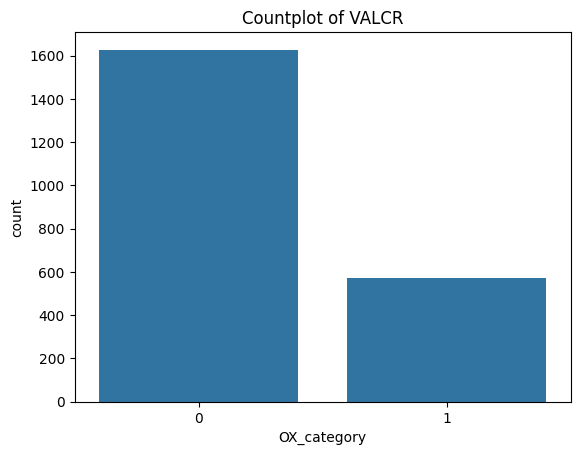


VALCU value counts:
OX_category
0    371
1    151
Name: count, dtype: int64


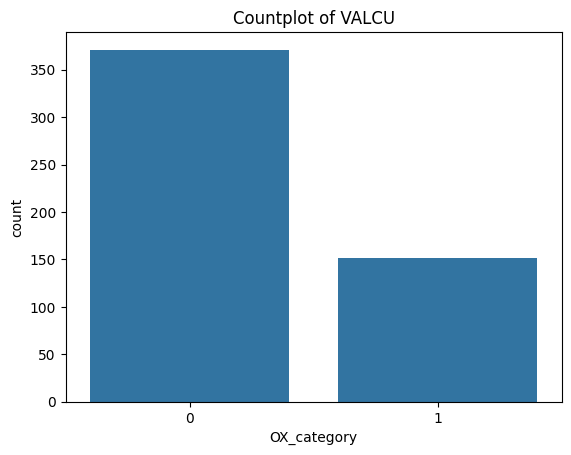


VALP value counts:
OX_category
0    833
1    116
Name: count, dtype: int64


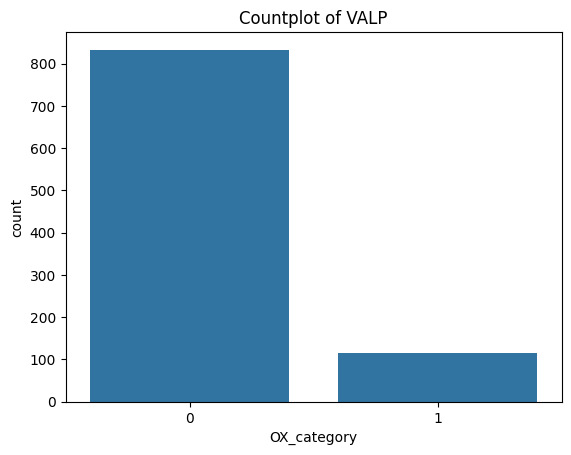


VALS value counts:
OX_category
0    129
1     46
Name: count, dtype: int64


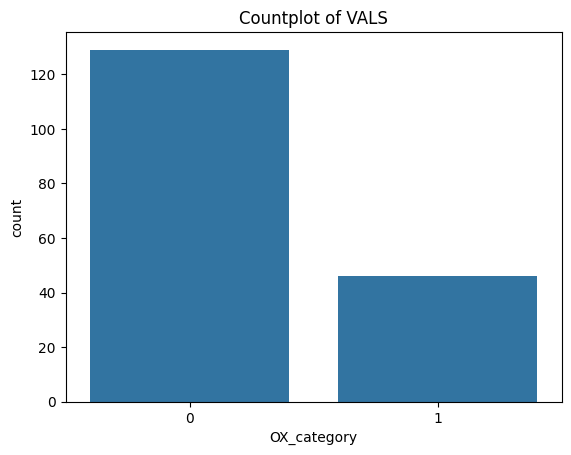

In [279]:


outlier_values={}
for column in ["VALSI","VALNI","VALMO","VALCR","VALCU","VALP","VALS"]:
    outlier_values[column] = df_final1.loc[outliers_index[column].index, "OX_category"]
    print(f"\n{column} value counts:")
    print(outlier_values[column].value_counts())
    sns.countplot(x=outlier_values[column])
    plt.title(f"Countplot of {column}")
    plt.show()

Mostly, the outliers follow the same proportion of good and bad oxygen levels, so they do not seem to be very relevant. This is not the case with VALSI. In the case of VALSI, outliers seem to have significant effect on oxygen levels. 

We then can formulate a hypothesis, with higher levels of SI, we will get higher levels of oxygen in the final product. Actually, if the SI levels go beyond 0.5, it is not advisable to start melting the heat, because it will probably have bad oxidation levels. 

VALP also seems interesting, because the outliers seem to perform better than the rest of the group. It seems as though if we add Phosphorus to our heat, we will have a more efficient management of oxygen. 

The first thing we will try to prove is that higher levels of SI lead to higher levels of oxygen. 

This hypothesis, however, is easily dismantled by the following graph: 

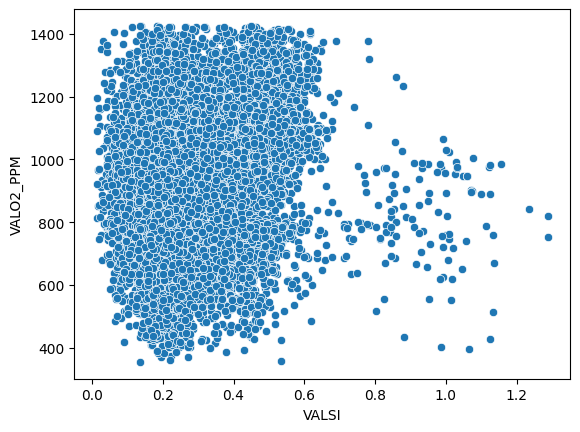

In [280]:
sns.scatterplot(x='VALSI', y='VALO2_PPM', data=df_final1)
plt.show()



As we can see, it is difficult to find a correlation between Si levels and O2 levels in the tapped product. This is ratified by the correlation matrix: 

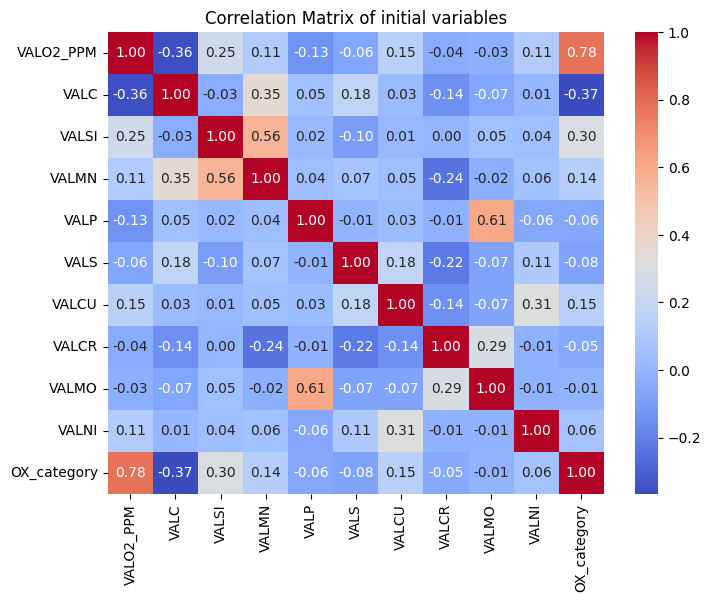

In [281]:
corr_matrix = df_final1.corr()  

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of initial variables")
plt.show()

Here we can see that none of the independent variables are too related with the dependent variable. Actually, we will drop some of them for now to make our work easier. 

In [282]:
df_final2=df_final1.drop(columns=["VALMN","VALS","VALCR","VALMO","VALNI"])

We have chosen to drop these columns for their weak relationship with the dependent variable. We chose to keep the Phosphorus levels because the outliers also seem to be very significant, but, as with the Si levels, it is unclear to us how to utilize this information. 

Since the outliers in VALP and VALSI seemed relevant, we will try to keep them in our model. We will transform both columns so that the extreme values do not affect our model as much. We will also try to use models that are resistant to outliers.


In [283]:
df_final2['log_si'] = np.log1p(df_final2['VALSI'])
df_final2['log_p'] = np.log1p(df_final2['VALP'])

Since we are performing a classification task with an imbalanced dataset, we perform undersampling to balance the good and the bad oxygen levels. Hopefully this will also reduce the number of Si outliers, since most of the Si values have bad oxygen levels. 

In [ ]:
from imblearn.under_sampling import ClusterCentroids

X_mat = df_final2.drop(columns=["OX_category","VALSI", "VALP"])
y_mat = df_final2["OX_category"]

centroid_sampler = ClusterCentroids(random_state=42)
X_resampled_mat, y_resampled_mat = centroid_sampler.fit_resample(X_mat, y_mat)

print(y_resampled_mat.value_counts())

OX_category
0    5508
1    5508
Name: count, dtype: int64


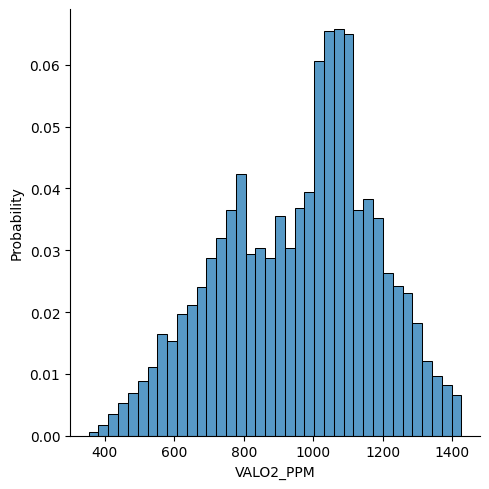

In [285]:
sns.displot(X_resampled_mat,x="VALO2_PPM",stat='probability')

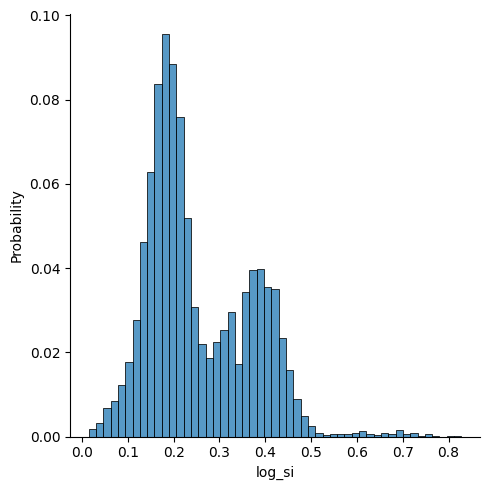

In [286]:
sns.displot(X_resampled_mat,x="log_si",stat='probability')

This graph looks a lot like two normal distributions, we will see if we can exploit that at some point along the way. 

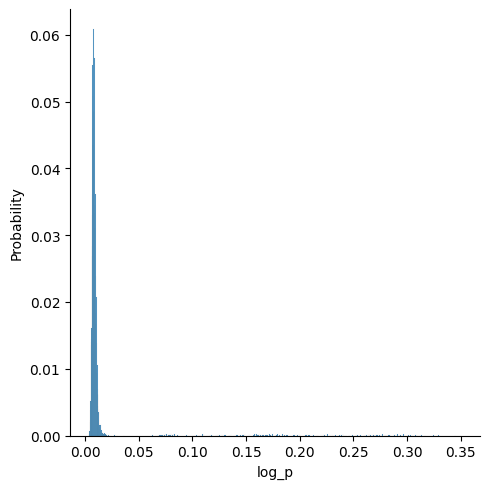

In [287]:
sns.displot(X_resampled_mat,x="log_p",stat='probability')

The Phosporus graph, however, looks like it will be very difficult to interpret without the help of a specialist. It seems easier to just delete the values that do not follow the normal pattern, or even not to take into account Phosphorus, as it did not have a huge correlation with the oxidation levels. We will try both strategies, keeping the phosphorus values and deleting them. 

In [288]:
df_resampled_mat = X_resampled_mat.copy()  
df_resampled_mat['target'] = y_resampled_mat

number_outliers_IQR(df_resampled_mat,"log_p")

11016
0.002479299132849778
Number of outliers for log_p: 613
Max outlier: 0.3506568716131694
Min outlier: 0.003294566949430031


We could not easily manage the outliers in P, so we will ignore the Phosphorus column all together for now. 

In [289]:
df_resampled_mat1=df_resampled_mat.drop(columns=["log_p"])

In [290]:
number_outliers_IQR(df_resampled_mat1,"log_si")

11016
0.1801327927164654
Number of outliers for log_si: 71
Max outlier: 0.8278091838033412
Min outlier: 0.6296214796800671


With Si, we only have 77 out of 11000 outliers when our transformation is complete. We drop them. 

In [291]:
index_out_si=find_outliers_IQR(df_resampled_mat1,"log_si")
df_final_mat= df_resampled_mat1.drop(index_out_si)

11016
0.1801327927164654
Number of outliers for log_si: 71
Max outlier: 0.8278091838033412
Min outlier: 0.6296214796800671


In [292]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled_mat=df_final_mat.copy()

df_scaled_mat[:] = scaler.fit_transform(df_scaled_mat)

We look at the correlations between our final variables:

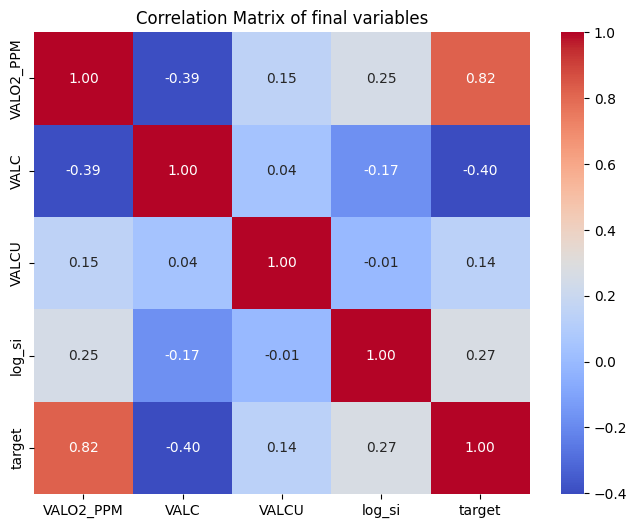

In [352]:
corr_matrix_mat = df_scaled_mat.corr()  

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_mat, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of final variables")
plt.show()

Now let's start with the analysis. We will try to implement some classification models. If this is not succesful, we will try to cluster the materials and see where that leads us. 

We will start with a Random Forest classifier, since it is resistant to outliers and easy to interpret.

In [294]:

inputs = df_scaled_mat.drop(['VALO2_PPM',"target"], axis='columns') 
target = df_scaled_mat["target"] 



In [295]:
X_train, X_test, y_train, y_test = train_test_split(inputs,target ,test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

8756
2189


In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier



We will do grid search for parameter tuning of most of the models we try

In [162]:
param_grid_rand = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [163]:
model_rand = RandomForestClassifier()


grid_search_rand = GridSearchCV(estimator=model_rand, param_grid=param_grid_rand, cv=5, n_jobs=-1)

grid_search_rand.fit(X_train, y_train)




GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 50, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [168]:
print("Best hyperparameters found: ", grid_search_rand.best_params_)

best_model_rand = grid_search_rand.best_estimator_



Best hyperparameters found:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [169]:
scores_rand = cross_val_score(best_model_rand, X_train, y_train, cv=10)
print("Cross-validation scores: ", scores_rand)

Cross-validation scores:  [0.74429224 0.74315068 0.74771689 0.71004566 0.73287671 0.71917808
 0.71542857 0.75657143 0.71771429 0.71542857]


In [170]:
scores_rand.mean()



np.float64(0.730240313111546)

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1093
           1       0.80      0.63      0.71      1096

    accuracy                           0.74      2189
   macro avg       0.75      0.74      0.74      2189
weighted avg       0.75      0.74      0.74      2189



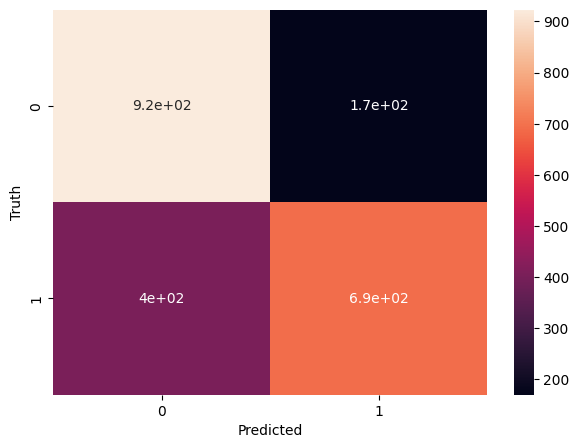

In [171]:
y_pred_rand = best_model_rand.predict(X_test)
cm_rand = confusion_matrix(y_test, y_pred_rand)
plt.figure(figsize=(7,5))
sns.heatmap(cm_rand, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test, y_pred_rand))

The results are not great, but they are also not bad. It turns out that we can more or less predict the O2 levels of a tapping heat by analyzing only the levels of Silicon, Carbon and Copper in the metal. Let's try with some other models.

We will try now with KNN. This model is not very robust when managing outliers, but maybe our logarithmic approach is enough to mitigate this weakness.

In [194]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [196]:
from sklearn.model_selection import GridSearchCV

numbers = list(range(1, 50))

param_grid_knn = {
    'n_neighbors': numbers,   
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'chebyshev'] ,  
}

In [197]:
grid_search_knn = GridSearchCV(estimator=knn, 
                           param_grid=param_grid_knn, 
                           cv=10,                     
                           verbose=1,                
                           n_jobs=-1) 

In [198]:
grid_search_knn.fit(X_train, y_train)

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [204]:
print("Best parameters found: ", grid_search_knn.best_params_)
print("Best cross-validation score: ", grid_search_knn.best_score_)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 36, 'weights': 'uniform'}
Best cross-validation score:  0.7261316373124591


In [205]:
best_model_knn = grid_search_knn.best_estimator_

In [230]:
scores_knn = cross_val_score(best_model_knn, inputs, target, cv=10)
print("Cross-validation scores: ", scores_knn)

print("Cross-validation scores avg: ", scores_knn.mean())

Cross-validation scores:  [0.76438356 0.72054795 0.67214612 0.57351598 0.66027397 0.66727605
 0.68829982 0.83180987 0.72669104 0.75137112]
Cross-validation scores avg:  0.7056315477532077


In [ ]:
y_pred_b_knn = best_model_knn.predict(X_test)
cm_b_knn = confusion_matrix(y_test, y_pred_b_knn)

array([[919, 174],
       [418, 678]])

Text(58.222222222222214, 0.5, 'Truth')

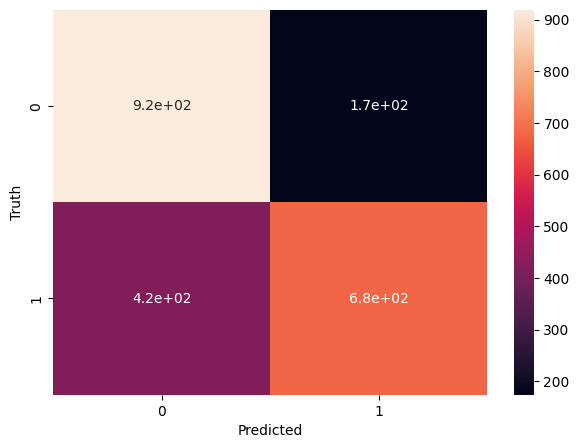

In [207]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(7,5))
sn.heatmap(cm_b_knn, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [208]:
print(classification_report(y_test, y_pred_b_knn))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      1093
           1       0.80      0.62      0.70      1096

    accuracy                           0.73      2189
   macro avg       0.74      0.73      0.73      2189
weighted avg       0.74      0.73      0.73      2189



Weirdly, KNN seems to get similar results to Random Forest for our processed data. Later we will add the Phosporus values to see if the scores are better with Random Forest. They will be a little bit better, but not a lot.

Also, it seems that for our models it is easier to predict when a batch is good. They have some trouble classiying the bad batches. Is it possible that all the good batches have something in common?  

We saw online that mahalanobis distance might be more robust against outliers.

In [210]:
cov_matrix_inv = np.linalg.inv(X_train.cov())

param_grid_knn_2 = {
    'n_neighbors': numbers,   
    'weights': ['uniform', 'distance'],  
    'metric': ['mahalanobis'] ,  
    'metric_params': [{'V': cov_matrix_inv}]
}

In [211]:
grid_search_knn_2 = GridSearchCV(estimator=knn, 
                           param_grid=param_grid_knn_2, 
                           cv=10,                     
                           verbose=1,                
                           n_jobs=-1) 

In [212]:
grid_search_knn_2.fit(X_train, y_train)

Fitting 10 folds for each of 98 candidates, totalling 980 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['mahalanobis'],
                         'metric_params': [{'V': array([[ 4.18730112e+01, -3.89491980e+00,  6.62880679e+00],
       [-3.89491980e+00,  2.13419495e+02, -7.14433314e-04],
       [ 6.62880679e+00, -7.14433314e-04,  3.27789735e+01]])}],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [213]:
print("Best parameters found: ", grid_search_knn_2.best_params_)
print("Best cross-validation score: ", grid_search_knn_2.best_score_)

Best parameters found:  {'metric': 'mahalanobis', 'metric_params': {'V': array([[ 4.18730112e+01, -3.89491980e+00,  6.62880679e+00],
       [-3.89491980e+00,  2.13419495e+02, -7.14433314e-04],
       [ 6.62880679e+00, -7.14433314e-04,  3.27789735e+01]])}, 'n_neighbors': 35, 'weights': 'uniform'}
Best cross-validation score:  0.7223642530984997


Mahalanobis distance seems to get similar results compared to the other metrics in KNN.

Let's try a simpler model that also has a way of dealing with outliers. We will mix Ridge and Lasso regression, and see what results we get.

In [68]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)


param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000],
    'l1_ratio': [0, 0.1, 0.25, 0.5, 0.9, 1]  # Mix of Lasso (L1) and Ridge (L2)
}



In [64]:
grid_search_lr = GridSearchCV(model_lr, param_grid_lr, cv=10, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)



GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000],
                         'l1_ratio': [0, 0.1, 0.25, 0.5, 0.9, 1]},
             scoring='accuracy')

In [65]:
print(f'Best parameters: {grid_search_lr.best_params_}')
print("Best cross-validation score: ", grid_search_lr.best_score_)

Best parameters: {'C': 10, 'l1_ratio': 0.1}
Best cross-validation score:  0.7018069145466406


In [66]:
best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test)



In [69]:
scores_lr = cross_val_score(best_model_lr, inputs, target, cv=10)
print("Cross-validation scores: ", scores_lr)

print("Cross-validation scores avg: ", scores_lr.mean())


Cross-validation scores:  [0.75890411 0.71141553 0.67123288 0.51415525 0.63105023 0.66179159
 0.70840951 0.81352834 0.73674589 0.74314442]
Cross-validation scores avg:  0.6950377734926081


              precision    recall  f1-score   support

           0       0.69      0.77      0.73      1093
           1       0.74      0.65      0.69      1096

    accuracy                           0.71      2189
   macro avg       0.71      0.71      0.71      2189
weighted avg       0.71      0.71      0.71      2189



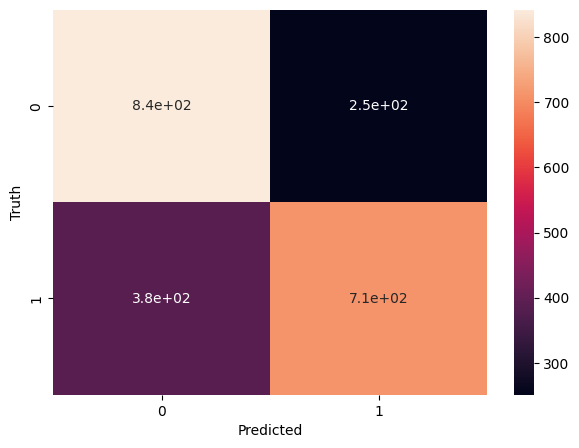

In [70]:

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(7,5))
sns.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test, y_pred_lr))

Logistic regression, even with correcting factors, seems to do worst than KNN and Random Forest. 

We will try XGBoost and Neural Networks before modifying our data further. 

XGBoost

Here, we change the split of the data so we can implement early stoppage and do a preliminary test of the model.

In [43]:
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(inputs, target, test_size=0.3, random_state=42)

print(len(X_temp2))
print(len(X_train2))

X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

print(len(X_val2))
print(len(X_test2))

3284
7661
1642
1642


In [44]:
import xgboost as xgb
from xgboost import XGBClassifier

dtrain = xgb.DMatrix(X_train2, label=y_train2)
dval = xgb.DMatrix(X_val2, label=y_val2)





In [45]:

params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',       
    'max_depth': 6,                 
    'eta': 0.3,                     
    'subsample': 0.8,               
    'colsample_bytree': 0.8,       
    'seed': 42                      
}

evallist = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evallist, early_stopping_rounds=10, verbose_eval=0)


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74       809
           1       0.77      0.67      0.72       833

    accuracy                           0.73      1642
   macro avg       0.74      0.73      0.73      1642
weighted avg       0.74      0.73      0.73      1642



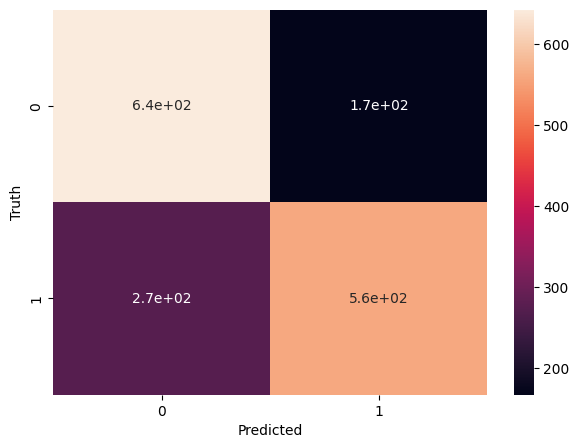

In [46]:
y_pred_prob = bst.predict(dval)
y_pred_xgb = [1 if prob > 0.5 else 0 for prob in y_pred_prob]


cm_lr = confusion_matrix(y_val2, y_pred_xgb)
plt.figure(figsize=(7,5))
sns.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print("Classification Report:\n", classification_report(y_val2, y_pred_xgb))

The results seem promising, so we try to do some hyperparameter tuning. We will keep the validation split for now, since it lets us implement early stoppage again. 

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid_xgb2 = {
    'max_depth': [3, 6, 10],
    'eta': [0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

xgb2_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', early_stopping_rounds=12, seed=42)


grid_search_xgb2 = GridSearchCV(
    estimator=xgb2_model,
    param_grid=param_grid_xgb2,
    cv=3,
    scoring='accuracy',
    verbose=1,
    
    
)




In [51]:
grid_search_xgb2.fit(X_train2, y_train2,  
            eval_set=[[X_val2, y_val2]],
                verbose=False)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=12,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'eta': [0.1, 0.2, 0.3], 'max_depth': [3, 6, 10],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [52]:
print(f'Best parameters: {grid_search_xgb2.best_params_}')
print("Best cross-validation score: ", grid_search_xgb2.best_score_)


Best parameters: {'colsample_bytree': 1.0, 'eta': 0.1, 'max_depth': 6, 'subsample': 0.7}
Best cross-validation score:  0.7237963168302618


              precision    recall  f1-score   support

           0       0.71      0.82      0.76       838
           1       0.78      0.65      0.71       804

    accuracy                           0.74      1642
   macro avg       0.74      0.73      0.73      1642
weighted avg       0.74      0.74      0.73      1642



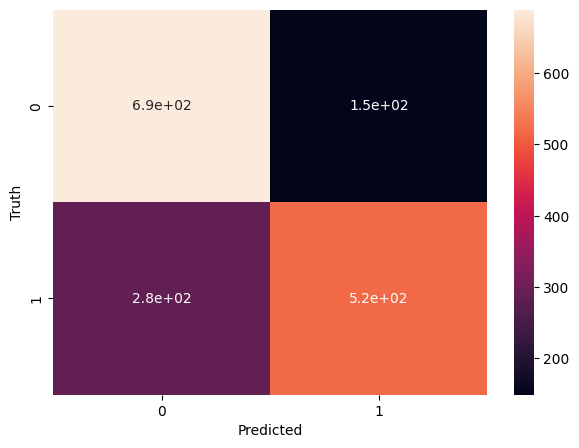

In [53]:
best_model_xgb2 = grid_search_xgb2.best_estimator_
y_pred_xgb2 = best_model_xgb2.predict(X_test2)


cm_lr = confusion_matrix(y_test2, y_pred_xgb2)
plt.figure(figsize=(7,5))
sns.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test2, y_pred_xgb2))

We do not get a significantly better result after doing hyperparameter tuning. 

Let's try Neural Networks.

In [58]:
import tensorflow as tf

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [60]:
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train2.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history = model_nn.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=50, batch_size=32)


Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6325 - loss: 0.6425 - val_accuracy: 0.7083 - val_loss: 0.5552
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7114 - loss: 0.5535 - val_accuracy: 0.7083 - val_loss: 0.5456
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7044 - loss: 0.5550 - val_accuracy: 0.7089 - val_loss: 0.5409
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7076 - loss: 0.5577 - val_accuracy: 0.7119 - val_loss: 0.5393
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7066 - loss: 0.5490 - val_accuracy: 0.7162 - val_loss: 0.5373
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7139 - loss: 0.5491 - val_accuracy: 0.7095 - val_loss: 0.5349
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7064 - loss: 0.5525 - val_accuracy: 0.7162 - val_loss: 0.5335
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7128 - loss: 0.5416 - val_accuracy: 0.

In [64]:
y_pred_nn = (model_nn.predict(X_test2) > 0.5).astype("int32")


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


              precision    recall  f1-score   support

           0       0.68      0.90      0.78       838
           1       0.84      0.57      0.68       804

    accuracy                           0.74      1642
   macro avg       0.76      0.73      0.73      1642
weighted avg       0.76      0.74      0.73      1642



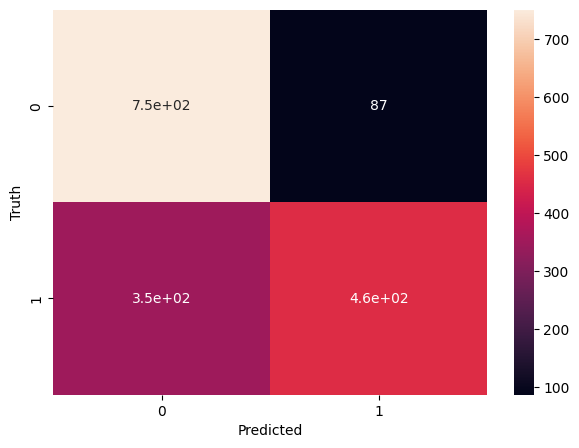

In [65]:
cm_lr = confusion_matrix(y_test2, y_pred_nn)
plt.figure(figsize=(7,5))
sns.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test2, y_pred_nn))

This model has a more extreme behaviour compared to the previous ones, mantaining the same accuracy. It follows the same trend as the other ones, recognizing way better the good batches than the bad ones. This raises suspicion in our minds, and we will try to see if we can exploit it later on. For now, we will try to tune a little bit more our model to see if we get better results. However, it looks like our models are struggling to get more than 75% accuracy. 

In [77]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train2.shape[1],)))

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [104]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory=R'C:\Users\quinito\ACADEMIA\tuning_logs',
                     project_name='opt1')



Reloading Tuner from C:\Users\quinito\ACADEMIA\tuning_logs\opt1\tuner0.json


In [105]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 55 Complete [00h 00m 06s]
val_accuracy: 0.7031963467597961

Best val_accuracy So Far: 0.7220319509506226
Total elapsed time: 00h 08m 05s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.01.



In [108]:
model_nn2 = tuner.hypermodel.build(best_hps)
history2 = model_nn.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history2.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7176 - loss: 0.5383 - val_accuracy: 0.7255 - val_loss: 0.5323
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7207 - loss: 0.5326 - val_accuracy: 0.7186 - val_loss: 0.5309
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7124 - loss: 0.5377 - val_accuracy: 0.7180 - val_loss: 0.5313
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7161 - loss: 0.5358 - val_accuracy: 0.7232 - val_loss: 0.5324
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7276 - loss: 0.5260 - val_accuracy: 0.7266 - val_loss: 0.5303
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7193 - loss: 0.5360 - val_accuracy: 0.7175 - val_loss: 0.5314
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7071 - loss: 0.5372 - val_accuracy: 0.7266 - val_loss: 0.5343
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7255 - loss: 0.5333 - val_accuracy: 0.

In [109]:
model_nn3 = tuner.hypermodel.build(best_hps)

model_nn3.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/5


C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6510 - loss: 0.6001 - val_accuracy: 0.7095 - val_loss: 0.5583
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7033 - loss: 0.5553 - val_accuracy: 0.7129 - val_loss: 0.5576
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7083 - loss: 0.5465 - val_accuracy: 0.7152 - val_loss: 0.5468
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6982 - loss: 0.5553 - val_accuracy: 0.7118 - val_loss: 0.5497
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6910 - loss: 0.5569 - val_accuracy: 0.7055 - val_loss: 0.5446


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.64      0.96      0.77      1093
           1       0.92      0.47      0.62      1096

    accuracy                           0.71      2189
   macro avg       0.78      0.71      0.70      2189
weighted avg       0.78      0.71      0.70      2189



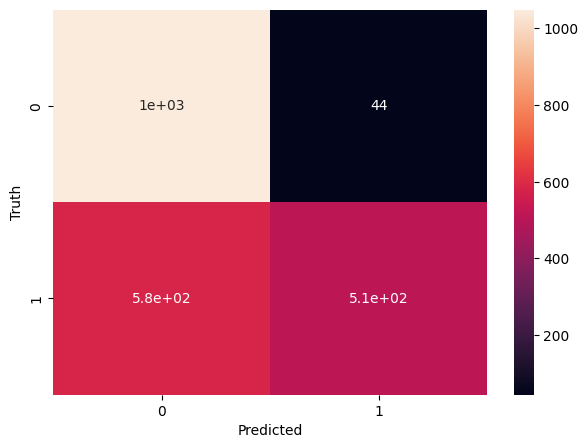

In [ ]:
y_pred_nn3 = (model_nn3.predict(X_test) > 0.5).astype("int32")
cm_lr = confusion_matrix(y_test, y_pred_nn3)
plt.figure(figsize=(7,5))
sns.heatmap(cm_lr, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_test, y_pred_nn3))

With the hypertuning the accuracy does not seem to improve a lot. We do see an increase in the tendency of identifying very well the good batches, but having trouble classifying the bad ones. 

We are going to analyze the distribution of the good and bad batches, to see if there is something to extract from it.

In [173]:
print(df_scaled_mat)


       VALO2_PPM      VALC     VALCU    log_si  target
0       0.297575  0.395077  0.341022  0.300386       0
1       0.494403  0.448788  0.391121  0.488988       0
2       0.391791  0.436943  0.323710  0.182650       0
3       0.131530  0.518148  0.368552  0.282121       0
4       0.571828  0.308254  0.390708  0.354215       0
...          ...       ...       ...       ...     ...
11011   0.609142  0.122704  0.246280  0.291552       1
11012   0.625933  0.510360  0.312996  0.144404       1
11013   0.638993  0.068920  0.354415  0.485357       1
11014   0.918843  0.435415  0.301091  0.325008       1
11015   0.670709  0.110213  0.187500  0.078905       1

[10945 rows x 5 columns]


good and bad batches: 


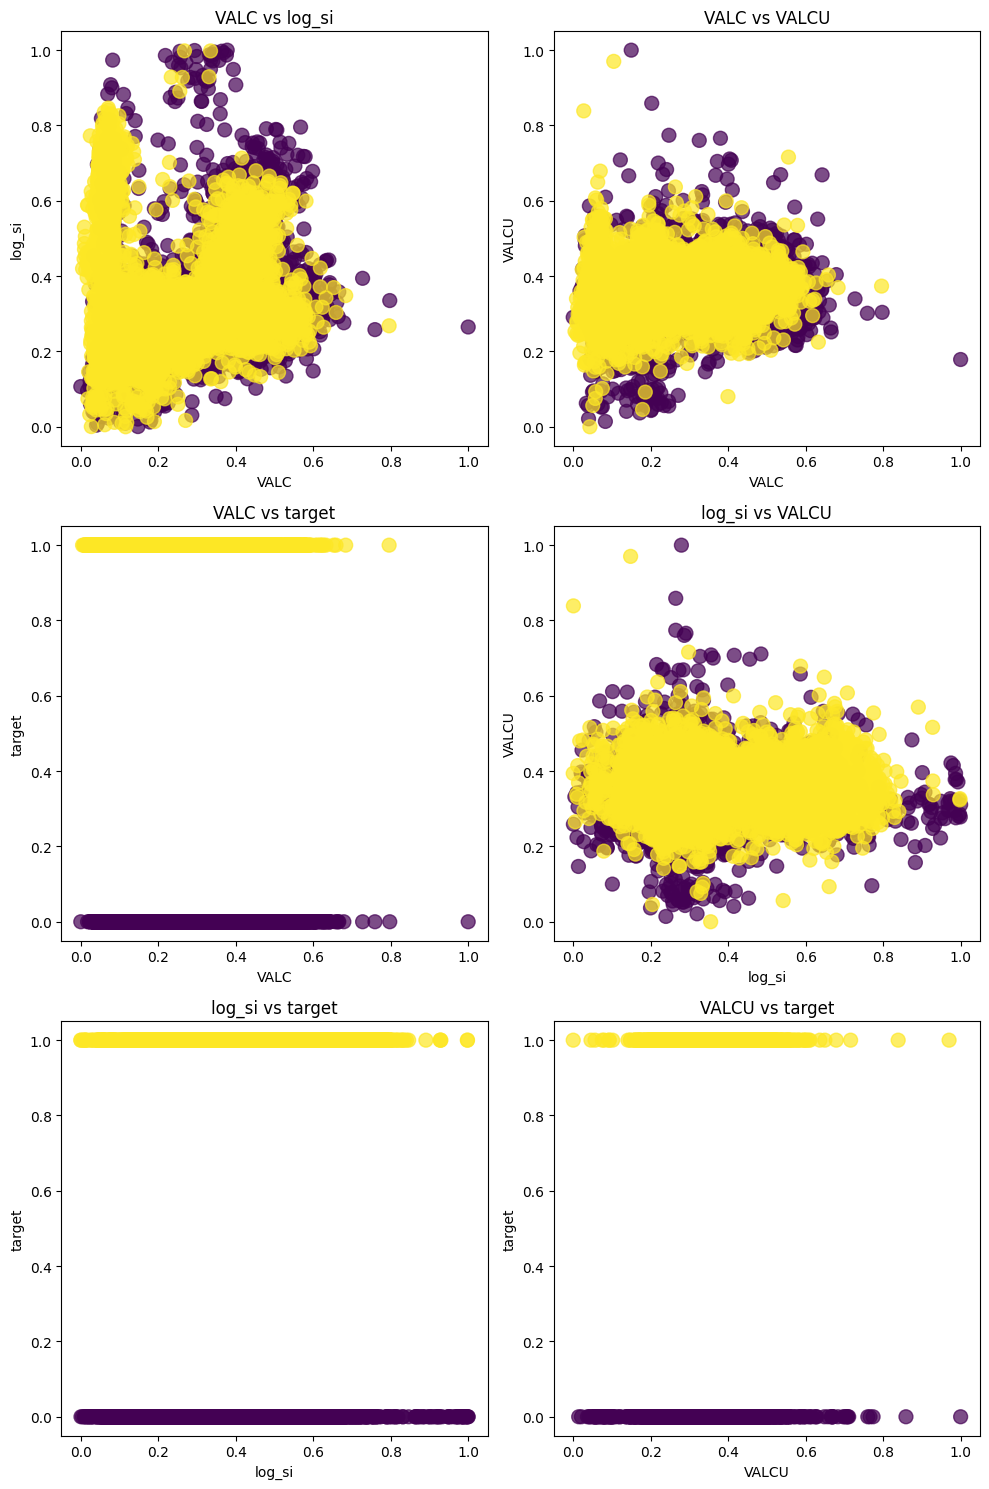

In [174]:
import itertools
print("good and bad batches: ")

features = ["VALC", "log_si", "VALCU","target"]

feature_pairs = list(itertools.combinations(features, 2))

n_cols = 2
n_rows = -(-len(feature_pairs) // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
axes = axes.flatten()  
for idx, (x_feature, y_feature) in enumerate(feature_pairs):
    ax = axes[idx]
    scatter = ax.scatter(
        df_scaled_mat[x_feature],
        df_scaled_mat[y_feature],
        c=df_scaled_mat["target"],  
        s=100,
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.set_title(f"{x_feature} vs {y_feature}")

for idx in range(len(feature_pairs), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

It does not seem possible to identify a clear difference between the two groups that could make the model prefer one or another.

We will run now some models incorporating the Phosphorus column, and see if it leads somewhere. If not, maybe it would be wise to try to combine the materials data with some other feature in our data. 

In [38]:

print(df_resampled_mat)

       VALO2_PPM      VALC     VALCU    log_si     log_p  target
0          673.0  0.299750  0.198600  0.196553  0.009455       0
1          884.0  0.336300  0.218800  0.310861  0.008464       0
2          774.0  0.328240  0.191620  0.125195  0.010383       0
3          495.0  0.383500  0.209700  0.185483  0.324617       0
4          967.0  0.240667  0.218633  0.229178  0.007537       0
...          ...       ...       ...       ...       ...     ...
11011     1007.0  0.114400  0.160400  0.191199  0.005286       1
11012     1025.0  0.378200  0.187300  0.102015  0.016070       1
11013     1039.0  0.077800  0.204000  0.308660  0.016857       1
11014     1339.0  0.327200  0.182500  0.211476  0.009653       1
11015     1073.0  0.105900  0.136700  0.062317  0.008762       1

[11016 rows x 6 columns]


First, we will try Random Forest and see how it does without normalization. Later, we will consider performing a robust scaling of the data, since we have a lot of outliers. 

In [40]:
inputsP = df_scaled_mat.drop(['VALO2_PPM',"target"], axis='columns') 
targetP = df_scaled_mat["target"] 
X_trainP, X_testP, y_trainP, y_testP = train_test_split(inputsP,targetP ,test_size=0.2, random_state=42)

print(len(X_trainP))
print(len(X_testP))

8756
2189


In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid_randP = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
model_randP = RandomForestClassifier()


grid_search_randP = GridSearchCV(estimator=model_randP, param_grid=param_grid_randP, cv=5, n_jobs=-1)

grid_search_randP.fit(X_trainP, y_trainP)



GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 50, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [43]:
print("Best hyperparameters found: ", grid_search_randP.best_params_)

best_model_randP = grid_search_randP.best_estimator_

scores_randP = cross_val_score(best_model_randP, inputs, target, cv=10)
print("Cross-validation scores: ", scores_randP)
scores_randP.mean()



Best hyperparameters found:  {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Cross-validation scores:  [0.77260274 0.70136986 0.67305936 0.58447489 0.66666667 0.67641682
 0.68190128 0.83272395 0.73765996 0.73583181]


np.float64(0.7062707336822686)

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1093
           1       0.79      0.64      0.71      1096

    accuracy                           0.74      2189
   macro avg       0.74      0.74      0.73      2189
weighted avg       0.74      0.74      0.73      2189



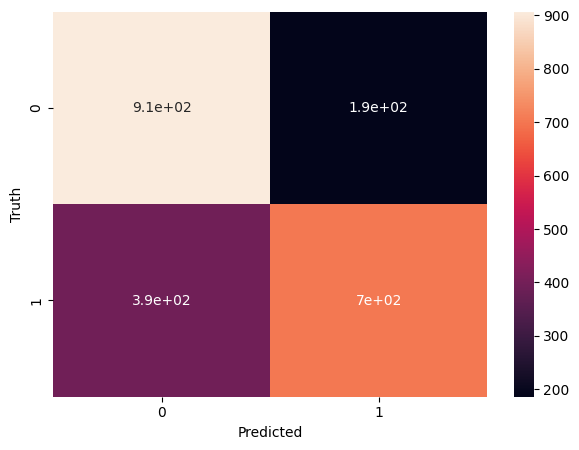

In [50]:
y_pred_randP = best_model_randP.predict(X_testP)
cm_randP = confusion_matrix(y_testP, y_pred_randP)
plt.figure(figsize=(7,5))
sns.heatmap(cm_randP, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_testP, y_pred_randP))

There is not a significant improval when taking into account phosphorus without scaling. Let's see what happens if we scale the data. 

In [45]:
from sklearn.preprocessing import RobustScaler

df_scaled_mat3=df_resampled_mat.copy()

scaler = RobustScaler()

columns_to_scale = df_scaled_mat3.columns.difference(['target','VALO2_PPM'])  

df_scaled_mat3[columns_to_scale] = scaler.fit_transform(df_scaled_mat3[columns_to_scale])

print(df_scaled_mat3.head())

   VALO2_PPM      VALC     VALCU    log_si       log_p  target
0      673.0  0.580173 -0.012246 -0.101652    0.519724       0
1      884.0  0.756957  0.650375  0.532926    0.120000       0
2      774.0  0.717973 -0.241212 -0.497792    0.893798       0
3      495.0  0.985254  0.351867 -0.163106  127.636861       0
4      967.0  0.294399  0.644907  0.079464   -0.253818       0


In [46]:
inputsPS = df_scaled_mat3.drop(['VALO2_PPM',"target"], axis='columns') 
targetPS = df_scaled_mat3["target"] 
X_trainPS, X_testPS, y_trainPS, y_testPS = train_test_split(inputsPS,targetPS ,test_size=0.2, random_state=42)

In [47]:
model_randPS = RandomForestClassifier()

In [48]:
grid_search_randPS = GridSearchCV(estimator=model_randPS, param_grid=param_grid_randP, cv=5, n_jobs=-1)

grid_search_randPS.fit(X_trainPS, y_trainPS)

C:\Users\quinito\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 50, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [51]:
print("Best hyperparameters found: ", grid_search_randPS.best_params_)

best_model_randPS = grid_search_randPS.best_estimator_

scores_randPS = cross_val_score(best_model_randPS, X_trainPS, y_trainPS, cv=10)
print("Cross-validation scores: ", scores_randPS)
scores_randPS.mean()


Best hyperparameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Cross-validation scores:  [0.74376417 0.76303855 0.76503973 0.74574347 0.75028377 0.76049943
 0.77298524 0.77752554 0.75595914 0.77525539]


np.float64(0.7610094435049842)

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1125
           1       0.79      0.71      0.75      1079

    accuracy                           0.76      2204
   macro avg       0.77      0.76      0.76      2204
weighted avg       0.77      0.76      0.76      2204



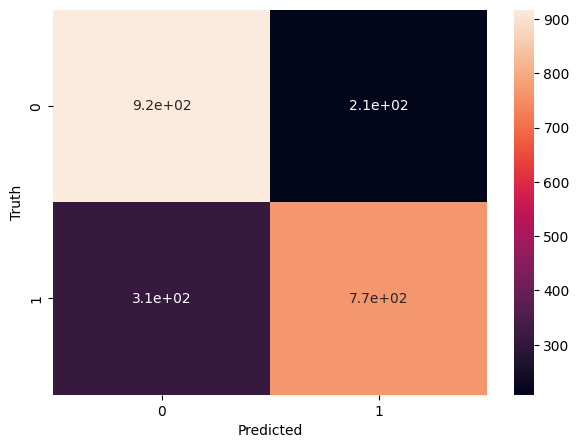

In [52]:
y_pred_randPS = best_model_randPS.predict(X_testPS)
cm_randPS = confusion_matrix(y_testPS, y_pred_randPS)
plt.figure(figsize=(7,5))
sns.heatmap(cm_randPS, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_testPS, y_pred_randPS))

We see a slight improvement when taking into account scaled phosphorus. Also, there is not as much imbalance between the predicted classes. Since Random Forest was one of the best models without phosphorus, we do not think the rest of the models will improve a lot the result we just got. It might be time to search for another strategy. Just in case, we will try Random Forest with all the columns. 

In [175]:
print(df_final1)


       VALO2_PPM    VALC   VALSI   VALMN    VALP    VALS   VALCU   VALCR  \
0          403.0  0.1457  0.2760  0.5306  0.1457  0.0167  0.1998  0.5240   
1          698.0  0.1359  0.2898  0.5285  0.1359  0.0048  0.1897  0.5159   
2          700.0  0.2183  0.3296  1.1203  0.2183  0.0273  0.2372  0.0942   
3          669.0  0.1436  0.2701  0.5227  0.1436  0.0092  0.1948  0.4835   
4          789.0  0.2368  0.2227  1.3179  0.2368  0.0165  0.2437  0.0839   
...          ...     ...     ...     ...     ...     ...     ...     ...   
20389      641.0  0.1122  0.0914  0.4283  0.0076  0.0322  0.1949  0.7945   
20390      611.0  0.1626  0.1577  0.6952  0.0101  0.0074  0.1891  0.0912   
20391     1073.0  0.1059  0.0643  0.4618  0.0088  0.0149  0.1367  0.4242   
20392      955.0  0.1440  0.1991  0.4518  0.0072  0.0030  0.1390  0.8715   
20393      947.0  0.1239  0.1820  0.4102  0.0076  0.0063  0.1026  0.7973   

        VALMO   VALNI  OX_category  
0      0.2760  0.1201            0  
1      0.2898

In [296]:
df_final3=df_final1.copy()
df_final3['log_si'] = np.log1p(df_final3['VALSI'])
df_final3['log_p'] = np.log1p(df_final3['VALP'])
df_final3['log_mn'] = np.log1p(df_final3['VALMN'])
df_final3['log_s'] = np.log1p(df_final3['VALS'])
df_final3['log_cr'] = np.log1p(df_final3['VALCR'])
df_final3['log_mo'] = np.log1p(df_final3['VALMO'])
df_final3['log_ni'] = np.log1p(df_final3['VALNI'])
df_final3['log_cu'] = np.log1p(df_final3['VALCU'])
df_final3['log_c'] = np.log1p(df_final3['VALC'])

df_final4=df_final3.drop(["VALSI","VALP","VALC","VALCU","VALMN","VALMO","VALCR","VALNI","VALS"],axis=1)

print(df_final4)



       VALO2_PPM  OX_category    log_si     log_p    log_mn     log_s  \
0          403.0            0  0.243730  0.136016  0.425660  0.016562   
1          698.0            0  0.254487  0.127425  0.424287  0.004789   
2          700.0            0  0.284878  0.197456  0.751558  0.026934   
3          669.0            0  0.239096  0.134181  0.420485  0.009158   
4          789.0            0  0.201062  0.212527  0.840662  0.016365   
...          ...          ...       ...       ...       ...       ...   
20389      641.0            0  0.087461  0.007571  0.356485  0.031692   
20390      611.0            0  0.146435  0.010049  0.527801  0.007373   
20391     1073.0            1  0.062317  0.008762  0.379669  0.014790   
20392      955.0            0  0.181571  0.007174  0.372804  0.002996   
20393      947.0            0  0.167208  0.007571  0.343732  0.006280   

         log_cr    log_mo    log_ni    log_cu     log_c  
0      0.421338  0.243730  0.113418  0.182155  0.136016  
1      

In [297]:
from imblearn.under_sampling import ClusterCentroids

X_mat4 = df_final4.drop(columns=["OX_category"])
y_mat4 = df_final4["OX_category"]

centroid_sampler = ClusterCentroids(random_state=42)
X_res_mat4, y_res_mat4 = centroid_sampler.fit_resample(X_mat4, y_mat4)

print(y_res_mat4.value_counts())


OX_category
0    5508
1    5508
Name: count, dtype: int64


In [298]:
print(X_res_mat4)

       VALO2_PPM    log_si     log_p    log_mn     log_s    log_cr    log_mo  \
0          673.0  0.207646  0.009335  0.808184  0.028774  0.100550  0.015615   
1          884.0  0.353071  0.007968  0.867778  0.031933  0.130452  0.023703   
2          774.0  0.168146  0.008039  0.540465  0.023310  0.083171  0.016517   
3          495.0  0.185483  0.324617  0.644325  0.018135  0.104270  0.185483   
4          967.0  0.223779  0.008165  0.810082  0.030123  0.078923  0.016018   
...          ...       ...       ...       ...       ...       ...       ...   
11011     1007.0  0.191199  0.005286  0.355224  0.003494  0.387301  0.013508   
11012     1025.0  0.102015  0.016070  0.599221  0.010346  0.099845  0.015381   
11013     1039.0  0.308660  0.016857  0.796155  0.011039  0.102918  0.013015   
11014     1339.0  0.211476  0.009653  0.871210  0.012225  0.090480  0.017938   
11015     1073.0  0.062317  0.008762  0.379669  0.014790  0.353610  0.211314   

         log_ni    log_cu     log_c  
0

In [299]:
from sklearn.preprocessing import RobustScaler

df_prescaled4=pd.concat([X_res_mat4,y_res_mat4],axis=1)

df_scal4=df_prescaled4.copy()

scaler = RobustScaler()

columns_to_scale4 = df_scal4.columns.difference(['OX_category','VALO2_PPM'])  

df_scal4[columns_to_scale4] = scaler.fit_transform(df_scal4[columns_to_scale4])

print(df_scal4.head())

   VALO2_PPM    log_si       log_p    log_mn     log_s    log_cr     log_mo  \
0      673.0 -0.019337    0.471404  0.092032  0.825095  0.254221  -0.259583   
1      884.0  0.820188   -0.080101  0.224041  1.144125  1.067934   0.951543   
2      774.0 -0.247364   -0.051582 -0.501003  0.273336 -0.218729  -0.124511   
3      495.0 -0.147279  127.636861 -0.270940 -0.249277  0.355441  25.178060   
4      967.0  0.073801   -0.000514  0.096236  0.961324 -0.334320  -0.199194   

     log_ni    log_cu     log_c  OX_category  
0 -0.348962  0.281166  0.456088            0  
1  1.380280 -0.030122  0.778192            0  
2 -0.230202 -0.426895  0.778391            0  
3  0.062931  0.394216  0.948142            0  
4 -0.059935  0.516960  0.309694            0  


In [300]:
inputsT=df_scal4.drop(["VALO2_PPM","OX_category"],axis=1)
targetT=df_scal4["OX_category"]

In [301]:
from sklearn.model_selection import train_test_split
X_trainT, X_testT, y_trainT, y_testT = train_test_split(inputsT,targetT ,test_size=0.2, random_state=42)

print(X_trainT)


        log_si     log_p    log_mn     log_s     log_cr    log_mo    log_ni  \
5092 -0.326509  0.120000 -0.939785 -1.556774  -0.392759  0.367483  0.834234   
2751 -0.076507  0.259689  0.072816 -0.149330   0.336633  0.115154  0.199210   
2025  0.846764 -0.640603  0.129689 -0.070937  -0.199392 -0.132515 -0.615415   
594  -0.241844  0.081608 -0.986176 -0.039587   0.049488  0.056911 -0.018120   
1558  2.269654  0.000000 -0.327479  0.511425  12.579929  0.470217 -0.198292   
...        ...       ...       ...       ...        ...       ...       ...   
5734  1.577979 -0.120036  0.212840 -0.856006  -0.617986 -0.900463 -0.406426   
5191 -0.212575  0.538199  0.012488  0.527571  -0.321974 -0.089582  0.104646   
5390  0.154944  0.359893  0.174748  0.353828  -1.058611 -0.560308 -1.063530   
860  -0.122983  0.652358  0.054416  0.460809   0.212907  0.149828 -0.065511   
7270 -0.533488 -1.201967 -1.117550  0.353828  -1.333756 -0.456936 -0.483561   

        log_cu     log_c  
5092  0.014142 -0.589745

In [188]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid_randTot = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

model_randTot = RandomForestClassifier()
grid_search_randTot = GridSearchCV(estimator=model_randTot, param_grid=param_grid_randTot, cv=5, n_jobs=-1)

In [189]:


grid_search_randTot.fit(X_trainT, y_trainT)
print("Best hyperparameters found: ", grid_search_randTot.best_params_)



Best hyperparameters found:  {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


In [191]:
best_model_randT = grid_search_randTot.best_estimator_

scores_randT = cross_val_score(best_model_randT, X_trainT, y_trainT, cv=10)
print("Cross-validation scores: ", scores_randT)
scores_randT.mean()



Cross-validation scores:  [0.80045351 0.84126984 0.82973893 0.81498297 0.81157775 0.84335982
 0.85244041 0.82973893 0.82973893 0.83314415]


np.float64(0.828644526293302)

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1125
           1       0.86      0.80      0.83      1079

    accuracy                           0.84      2204
   macro avg       0.84      0.84      0.84      2204
weighted avg       0.84      0.84      0.84      2204



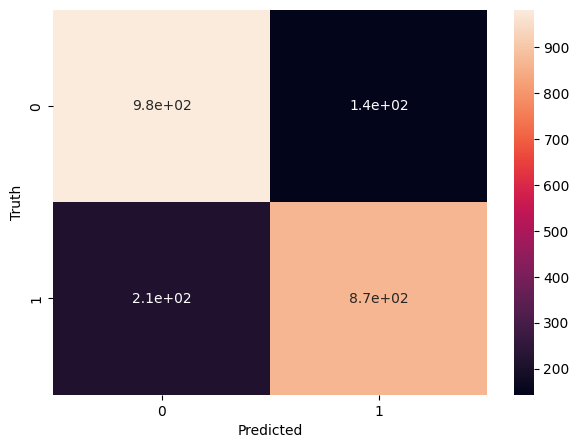

In [192]:
y_pred_randT = best_model_randT.predict(X_testT)
cm_randT = confusion_matrix(y_testT, y_pred_randT)
plt.figure(figsize=(7,5))
sns.heatmap(cm_randT, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(classification_report(y_testT, y_pred_randT))

Surprisingly for us, the model seems to do way better now. It would probably be worth it to tune it a little bit more.

Another step that we have not proceded with but could be helpful is to analyze the misclasifications and see if we could find patterns in them that are different to the whole dataset. (comparing graphs of the whole dataset versus the misclasifications) 

With a little more tuning, the model can maybe be used to modify slightly the furnace's process. Maybe if a material is predicted to be unfit, it can be modified and evaluated again. The number of defects could be drastically reduced if the modifying is cheap and easy enough. 

As an extra, we decided to analyze the characteristics of some clusters, to see if they could have any relevance in the O2 final levels. 

If we look back, there was a suspicious distribution of the log_si values

In [302]:
X_clustering, y_clustering = X_resampled_mat.copy(), y_resampled_mat.copy()

In [303]:
print(X_clustering)

       VALO2_PPM      VALC     VALCU    log_si     log_p
0          673.0  0.299750  0.198600  0.196553  0.009455
1          884.0  0.336300  0.218800  0.310861  0.008464
2          774.0  0.328240  0.191620  0.125195  0.010383
3          495.0  0.383500  0.209700  0.185483  0.324617
4          967.0  0.240667  0.218633  0.229178  0.007537
...          ...       ...       ...       ...       ...
11011     1007.0  0.114400  0.160400  0.191199  0.005286
11012     1025.0  0.378200  0.187300  0.102015  0.016070
11013     1039.0  0.077800  0.204000  0.308660  0.016857
11014     1339.0  0.327200  0.182500  0.211476  0.009653
11015     1073.0  0.105900  0.136700  0.062317  0.008762

[11016 rows x 5 columns]


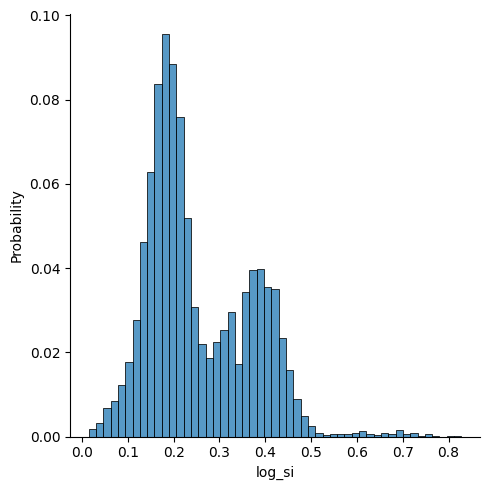

In [304]:
sns.displot(X_resampled_mat,x="log_si",stat='probability')

It might be worth it to see if the materials can be split into two groups following two normal distributions, at least in the case of Si. 

Actually, after downsampling, the O2 levels seemed to follow a relatively similar distribution:

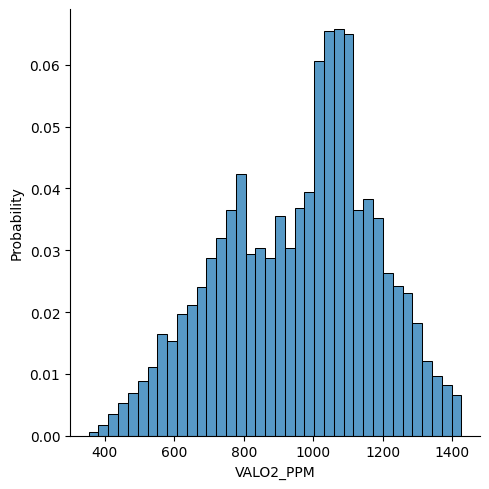

In [305]:
sns.displot(X_resampled_mat,x="VALO2_PPM",stat='probability')

Carbon values do not follow it as much, even after a logarithmic transformation. 

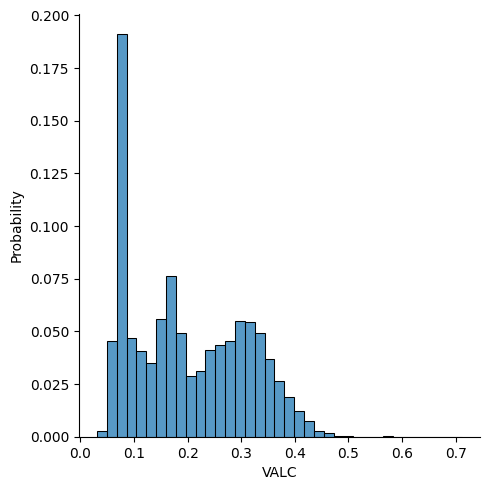

In [306]:
sns.displot(X_resampled_mat,x="VALC",stat='probability')

In [309]:
X_clustering['log_c'] = np.log1p(X_clustering['VALC'])



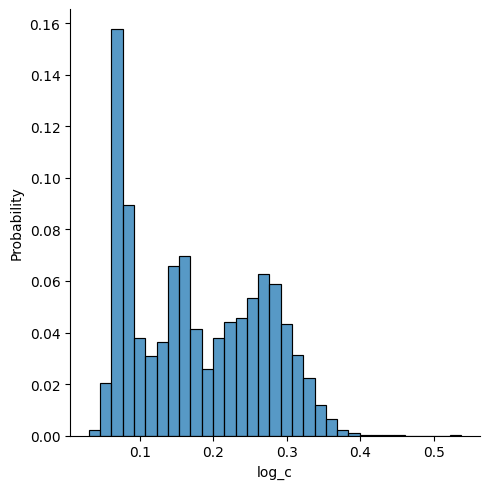

In [312]:
sns.displot(X_clustering,x="log_c",stat='probability')

In [ ]:
from sklearn.preprocessing import RobustScaler

X_clustering2=X_clustering.copy()

scaler = RobustScaler()

columns_to_scale = X_clustering2.columns

X_clustering2[columns_to_scale] = scaler.fit_transform(X_clustering2[columns_to_scale])

print(X_clustering2.head())

df_clustering=pd.concat([X_clustering2,y_clustering],axis=1)

   VALO2_PPM      VALC     VALCU    log_si       log_p     log_c
0  -1.033123  0.580173 -0.012246 -0.101652    0.519724  0.556415
1  -0.367508  0.756957  0.650375  0.532926    0.120000  0.715780
2  -0.714511  0.717973 -0.241212 -0.497792    0.893798  0.681014
3  -1.594637  0.985254  0.351867 -0.163106  127.636861  0.915251
4  -0.105678  0.294399  0.644907  0.079464   -0.253818  0.289071


array([[<Axes: title={'center': 'VALO2_PPM'}>,
        <Axes: title={'center': 'VALC'}>,
        <Axes: title={'center': 'VALCU'}>],
       [<Axes: title={'center': 'log_si'}>,
        <Axes: title={'center': 'log_p'}>,
        <Axes: title={'center': 'log_c'}>],
       [<Axes: title={'center': 'OX_category'}>, <Axes: >, <Axes: >]],
      dtype=object)

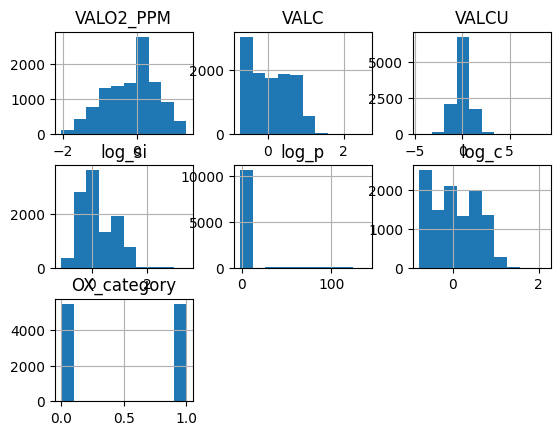

In [314]:
df_clustering.hist()

Now we can apply some clustering. The first ones we would like to try are the ones that assume there are normal distributions hidden in the data. 

we define a function here that will be used to evaluate our clustering.

In [315]:
import itertools
def my_graph_report(labels,name_algorithm,df):

    print(name_algorithm, " clustering: ")

    features = ["VALC", "log_si", "log_p", "VALCU","VALO2_PPM"]

    feature_pairs = list(itertools.combinations(features, 2))

    n_cols = 2
    n_rows = -(-len(feature_pairs) // n_cols) 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
    axes = axes.flatten()  
    for idx, (x_feature, y_feature) in enumerate(feature_pairs):
        ax = axes[idx]
        scatter = ax.scatter(
            df[x_feature],
            df[y_feature],
            c=labels,  
            s=100,
            alpha=0.7
        )
        ax.set_xlabel(x_feature)
        ax.set_ylabel(y_feature)
        ax.set_title(f"{x_feature} vs {y_feature}")

    for idx in range(len(feature_pairs), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

We will apply clustering without the target values, since they might influence a lot the clustering results, and we already saw that the clusters given by the two categories do not bring much light to our problem.

In [316]:
df_clus_o2=df_clustering.drop(["OX_category","log_c"],axis=1)

df_clus_o2.dtypes

VALO2_PPM    float64
VALC         float64
VALCU        float64
log_si       float64
log_p        float64
dtype: object

GMM  clustering: 


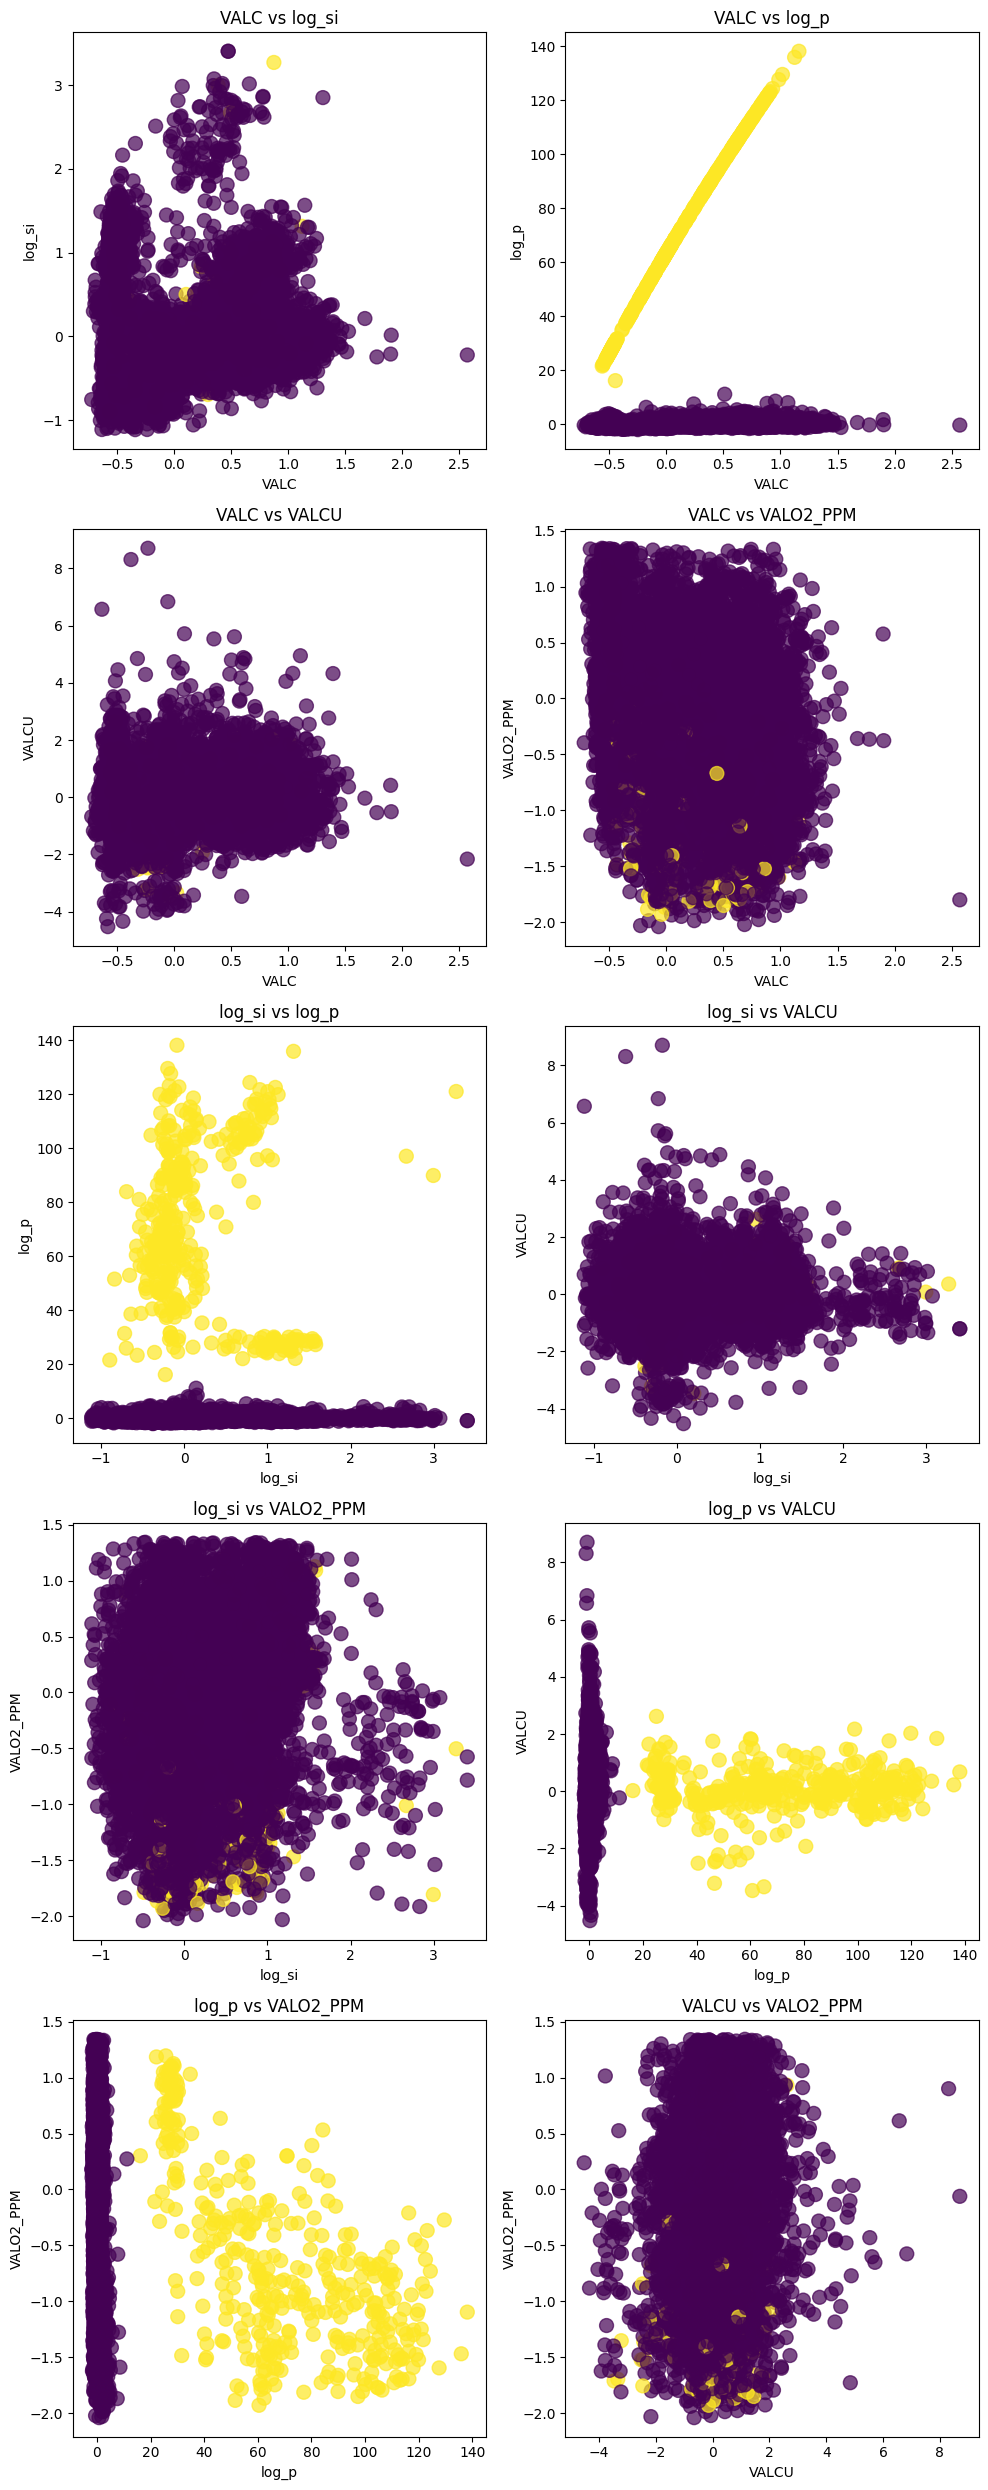

Score of Gaussian =  0.9489867303739645


In [317]:
from sklearn.mixture import GaussianMixture
from numpy import unique
from sklearn import metrics

model_gb = GaussianMixture(n_components=2)
model_gb.fit(df_clus_o2)
#
yhat_gb = model_gb.predict(df_clus_o2)
clusters_gb = unique(yhat_gb)
my_graph_report(yhat_gb, "GMM",df_clus_o2)
score_gb = metrics.silhouette_score(df_clus_o2, yhat_gb)


print("Score of Gaussian = ", score_gb)

In [318]:
clusters, counts = np.unique(yhat_gb, return_counts=True)

for cluster, count in zip(clusters, counts):
    print(f"Cluster {cluster}: {count} elements")

Cluster 0: 10626 elements
Cluster 1: 390 elements


This iteration is just detecting the outliers in Phosphorus, we are going to drop them and run the clustering again. 

In [319]:
mask = yhat_gb != 1

df_filt_o2 = df_clus_o2[mask]

y_clusFilt=y_clustering[mask]

print(df_filt_o2)
print(y_clusFilt)

       VALO2_PPM      VALC     VALCU    log_si     log_p
0      -1.033123  0.580173 -0.012246 -0.101652  0.519724
1      -0.367508  0.756957  0.650375  0.532926  0.120000
2      -0.714511  0.717973 -0.241212 -0.497792  0.893798
4      -0.105678  0.294399  0.644907  0.079464 -0.253818
5      -1.298107  0.927454 -0.155760 -0.144214 -0.150220
...          ...       ...       ...       ...       ...
11011   0.020505 -0.316326 -1.265322 -0.131377 -1.161844
11012   0.077287  0.959619 -0.382921 -0.626477  3.187843
11013   0.121451 -0.493352  0.164890  0.520708  3.505246
11014   1.067823  0.712943 -0.540375 -0.018809  0.599643
11015   0.228707 -0.357439 -2.042753 -0.846857  0.239964

[10626 rows x 5 columns]
0        0
1        0
2        0
4        0
5        0
        ..
11011    1
11012    1
11013    1
11014    1
11015    1
Name: OX_category, Length: 10626, dtype: int64


GMM  clustering: 


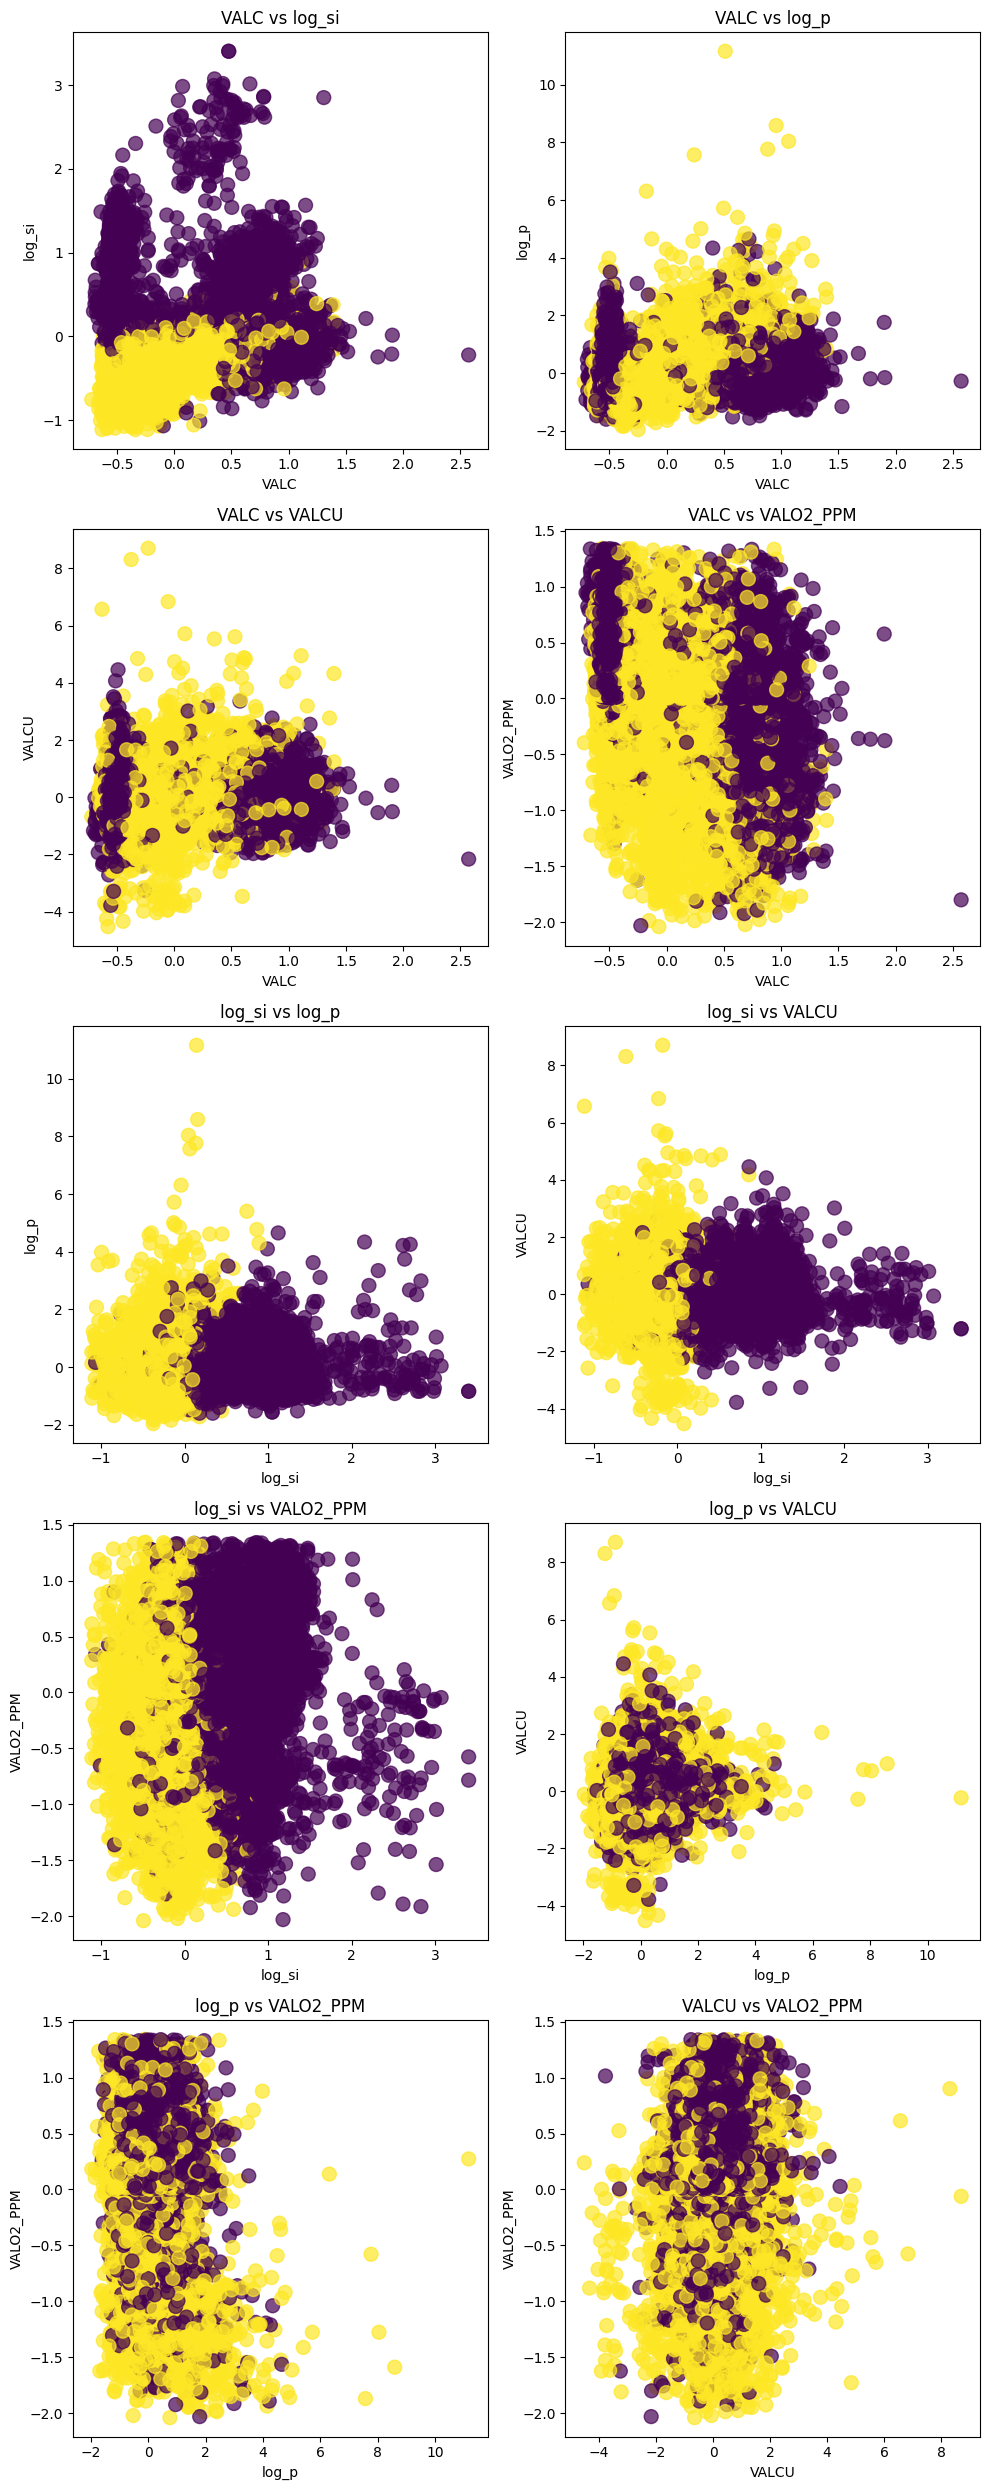

Score of Gaussian =  0.11160884218381655


In [320]:
model_gb2 = GaussianMixture(n_components=2)
model_gb2.fit(df_filt_o2)
#
yhat_gb2 = model_gb2.predict(df_filt_o2)
clusters_gb2 = unique(yhat_gb2)
my_graph_report(yhat_gb2, "GMM",df_filt_o2)
score_gb2 = metrics.silhouette_score(df_filt_o2, yhat_gb2)


print("Score of Gaussian = ", score_gb2)

In [321]:
clusters, counts = np.unique(yhat_gb2, return_counts=True)

for cluster, count in zip(clusters, counts):
    print(f"Cluster {cluster}: {count} elements")

Cluster 0: 5450 elements
Cluster 1: 5176 elements


It looks like we might have found something similar to the silicon groups we were looking for, but we do not see a lot of difference in the VALO2_PPM values between the two groups. 

Shilouette score is also not so good. 

Just in case, we explore a little bit deeper, because maybe the graphs are not telling all the truth.

In [ ]:
df_count=df_filt_o2.copy()
df_count["Clusters"]=yhat_gb2
df_count["OX_category"]=y_clusFilt.values

counts = df_count.groupby(['Clusters', 'OX_category']).size()

counts = counts.reset_index(name='Count')

print(counts)

   Clusters  OX_category  Count
0         0            0   2030
1         0            1   3420
2         1            0   3169
3         1            1   2007


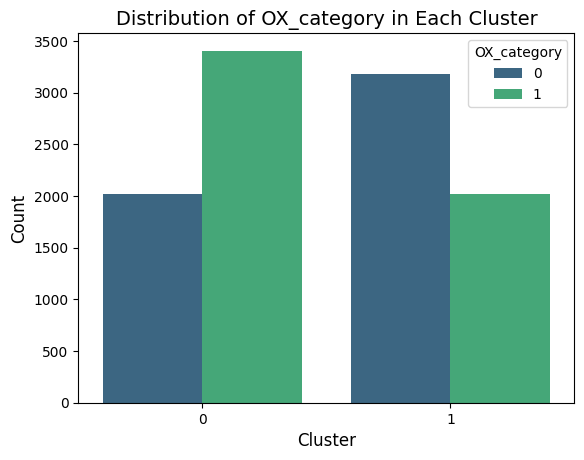

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Cluster': [0, 0, 1, 1],
    'OX_category': [0, 1, 0, 1],
    'Count': [2020, 3406, 3179, 2021]
}
df = pd.DataFrame(data)

sns.barplot(x='Cluster', y='Count', hue='OX_category', data=df, palette='viridis')

plt.title('Distribution of OX_category in Each Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='OX_category', loc='upper right')

plt.show()

It does look like the clustering was at least partially justified. The first group appears to have significantly more defects than the second one. 

In the factory, it could be proposed to treat differently these two groups, refining a little bit the process with metals of group 0. 

To see if there is something else missing in the data, we are going to try Kmeans and Hierarchical clustering. Hierarchical clustering probably fits better this data, since it might be fuzzy and the clusters might not have a specific shape, but we will try both nonetheless. 

This will tell us if the "normal/abnormal" metal problem is more complex than we thought. 

In [324]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy

In [325]:
print(df_filt_o2)

       VALO2_PPM      VALC     VALCU    log_si     log_p
0      -1.033123  0.580173 -0.012246 -0.101652  0.519724
1      -0.367508  0.756957  0.650375  0.532926  0.120000
2      -0.714511  0.717973 -0.241212 -0.497792  0.893798
4      -0.105678  0.294399  0.644907  0.079464 -0.253818
5      -1.298107  0.927454 -0.155760 -0.144214 -0.150220
...          ...       ...       ...       ...       ...
11011   0.020505 -0.316326 -1.265322 -0.131377 -1.161844
11012   0.077287  0.959619 -0.382921 -0.626477  3.187843
11013   0.121451 -0.493352  0.164890  0.520708  3.505246
11014   1.067823  0.712943 -0.540375 -0.018809  0.599643
11015   0.228707 -0.357439 -2.042753 -0.846857  0.239964

[10626 rows x 5 columns]


Agglomerative Clustering

In [326]:
model_ac = AgglomerativeClustering(n_clusters=1, linkage='ward')  

model_ac.fit(df_filt_o2)

labels_ac = model_ac.labels_

clusters_ac = np.unique(labels_ac)
print("Clusters of Agglomerative Clustering", clusters_ac)

Clusters of Agglomerative Clustering [0]


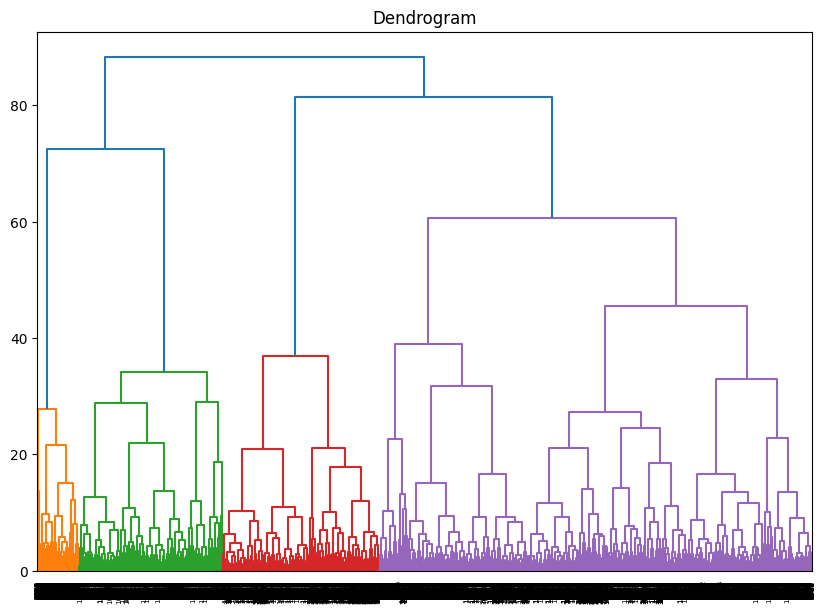

In [327]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(df_filt_o2, method='ward')  

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.show()

The dendogram seems to suggest that the best division might be in four or five groups. If we take this into account and explore again with GMM, we might come to more insights. Let's see what Kmeans suggests, and then we will try GMM again with the new k. 

Kmeans++

Text(0.5, 1.0, 'Elbow plot for optimal number of clusters')

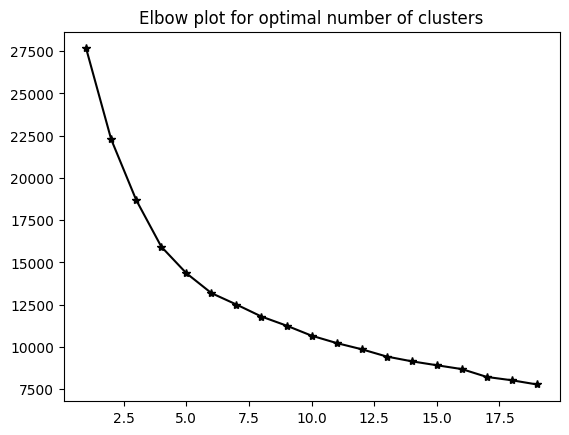

In [328]:
wscc = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, init="k-means++",random_state=0)
    kmeans.fit(df_filt_o2)
    wscc.append(kmeans.inertia_)

plt.plot(range(1,20),wscc,marker="*",c="black")
plt.title("Elbow plot for optimal number of clusters")

In [329]:
k_means = KMeans(n_clusters=4)
k_means.fit(df_filt_o2)

KMeans(n_clusters=4)

Trying manually with k from 2 to 5, the best k for kmeans seems to be 4. We better the shilouette score we had achieved previously, so it seems like we might be in the right path.

In [330]:
score_km = metrics.silhouette_score(df_filt_o2, k_means.labels_)

print("Score = ", score_km)

Score =  0.2203784480125202


Agglomerative clustering 4 clusters.

In [331]:
model_ac2 = AgglomerativeClustering(n_clusters=4, linkage='ward')  

model_ac2.fit(df_filt_o2)

labels_ac2 = model_ac2.labels_





In [332]:
silhouette_avg_ac2 = metrics.silhouette_score(df_filt_o2, labels_ac2)

print(f"Silhouette Score for AC 4 clusters: {silhouette_avg_ac2:.2f}")

Silhouette Score for AC 4 clusters: 0.19


GMM 4 clusters

In [333]:
model_gb4 = GaussianMixture(n_components=4)
model_gb4.fit(df_filt_o2)
#
yhat_gb4 = model_gb4.predict(df_filt_o2)
clusters_gb4 = unique(yhat_gb4)
score_gb4 = metrics.silhouette_score(df_filt_o2, yhat_gb4)


print("Score of Gaussian 4 clusters = ", score_gb4)

Score of Gaussian 4 clusters =  0.14343847705354212


Turns out Kmeans might get the best score. Let's try DBSCAN just in case.

In [334]:
from sklearn.cluster import DBSCAN

model_dbs = DBSCAN(eps=1.5, min_samples=25)

yhat_dbs = model_dbs.fit_predict(df_filt_o2)

clusters = unique(yhat_dbs)

print(clusters)


[-1  0]


DBSCAN  clustering: 


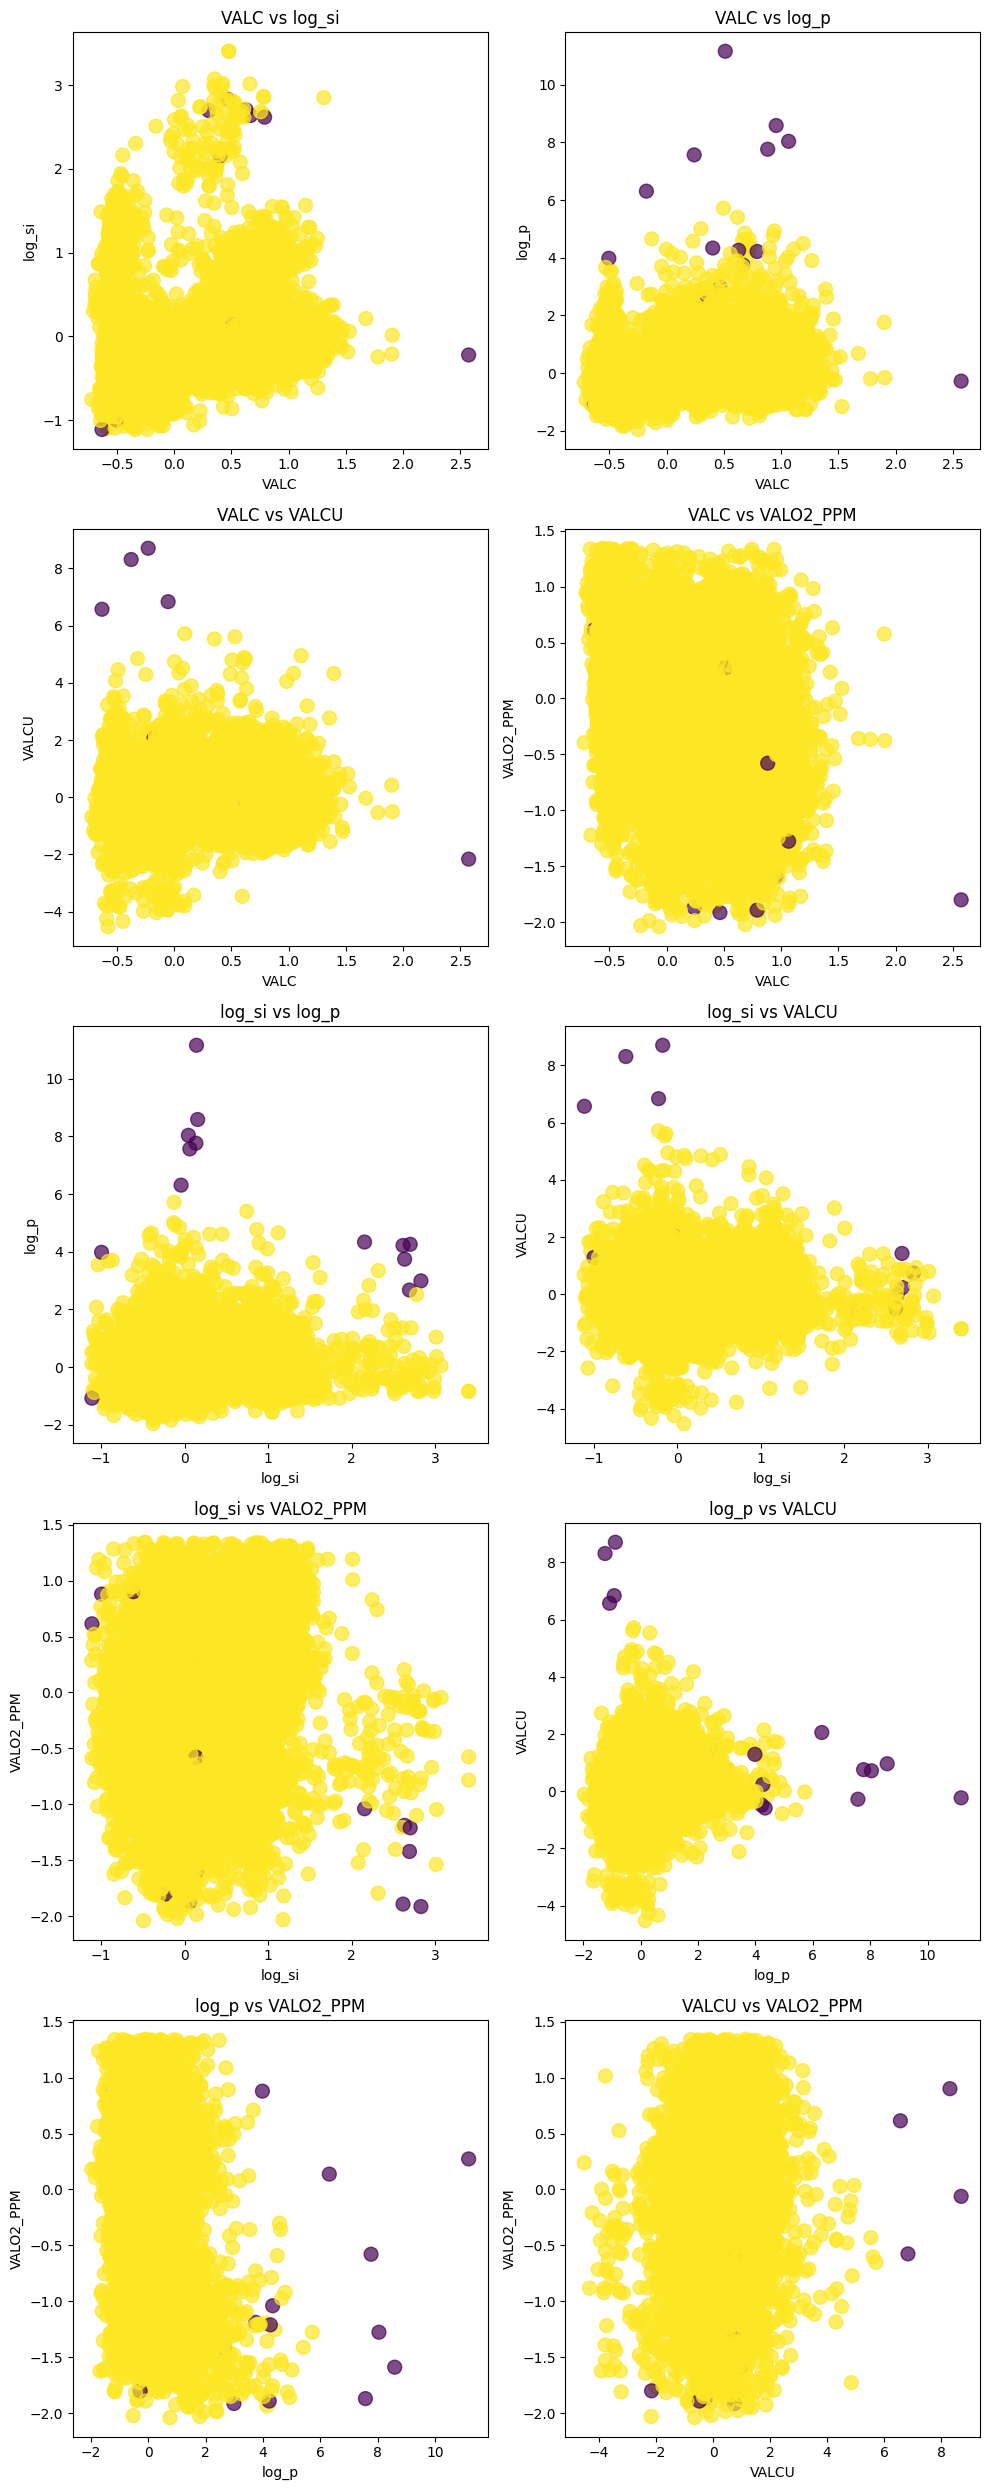

In [335]:
my_graph_report(yhat_dbs, "DBSCAN",df_filt_o2)


DBSCAN mostly finds noise or gets too many clusters and very bad shilouette scores. 

The clusters in KMeans seemed promising. Let's see how they looked like. 

K means 4 clusters  clustering: 


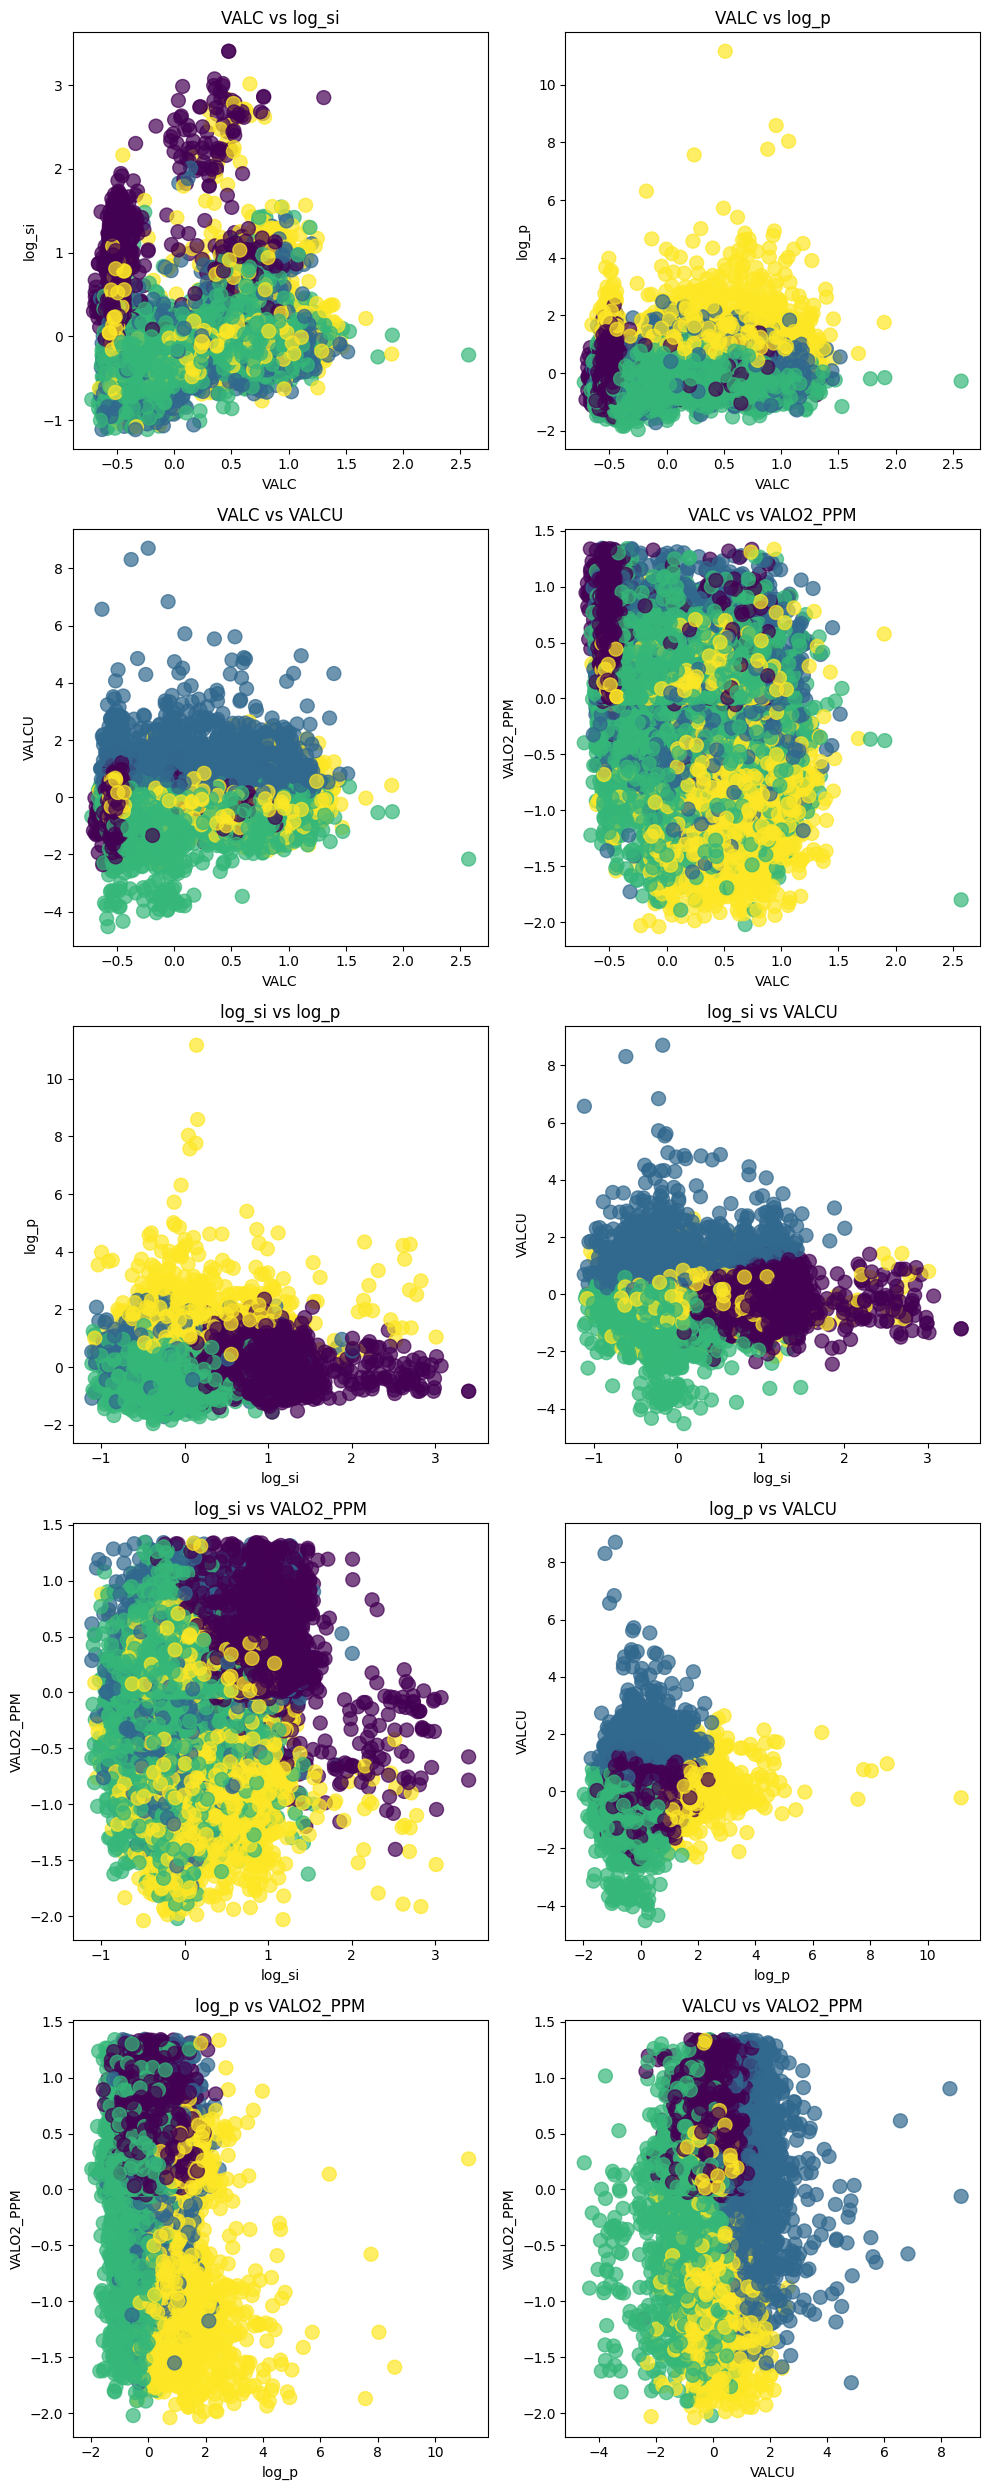

In [336]:
my_graph_report(k_means.labels_, "K means 4 clusters",df_filt_o2)


In [337]:
clustersk, countsk = np.unique(k_means.labels_, return_counts=True)

for cluster, count in zip(clustersk, countsk):
    print(f"Cluster {cluster}: {count} elements")

Cluster 0: 2344 elements
Cluster 1: 2409 elements
Cluster 2: 3793 elements
Cluster 3: 2080 elements


In [338]:
print(y_clusFilt)
print(k_means.labels_)


0        0
1        0
2        0
4        0
5        0
        ..
11011    1
11012    1
11013    1
11014    1
11015    1
Name: OX_category, Length: 10626, dtype: int64
[3 1 3 ... 3 2 2]


In [ ]:
import pandas as pd

df_clusterskm = pd.DataFrame({
    'Cluster': k_means.labels_, 
    'OX_category': y_clusFilt.values 
})

cluster_counts = df_clusterskm.groupby(['Cluster', 'OX_category']).size().reset_index(name='Count')

print(cluster_counts)


   Cluster  OX_category  Count
0        0            0    192
1        0            1   2152
2        1            0    763
3        1            1   1646
4        2            0   2381
5        2            1   1412
6        3            0   1863
7        3            1    217


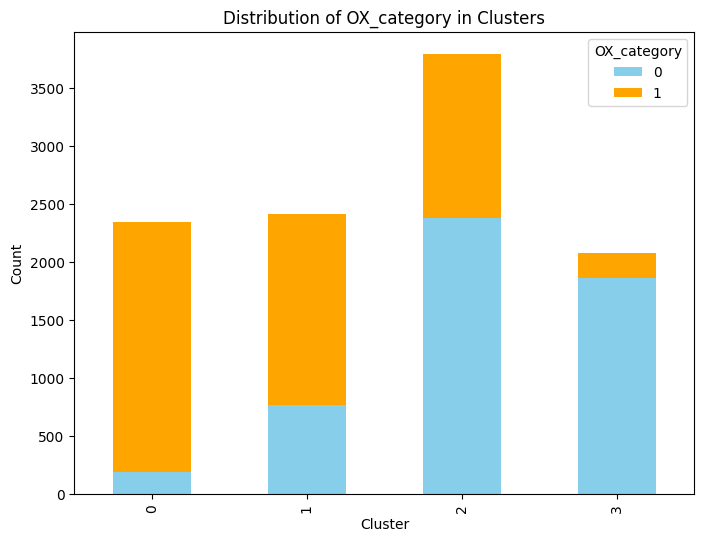

In [340]:
import matplotlib.pyplot as plt

pivot_table = cluster_counts.pivot(index='Cluster', columns='OX_category', values='Count')

pivot_table.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'orange'])
plt.title('Distribution of OX_category in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='OX_category', labels=['0', '1'])
plt.show()

These results seem to help us even more. However, the results are biased by the use of VALO2_PPM in the data. This was a mistake on our part. We do one last iteration of KMeans without VALO2_PPM in the data. 

In [342]:
df_nobias=df_filt_o2.drop(["VALO2_PPM"],axis=1)


Text(0.5, 1.0, 'Elbow plot for optimal number of clusters no bias')

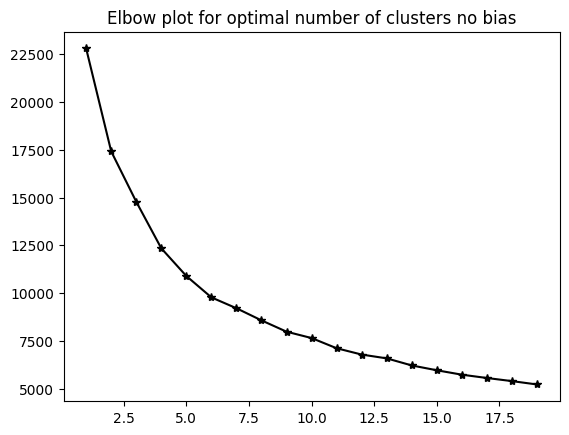

In [345]:
wscc_n = []
for i in range(1,20):
    kmeans_nob = KMeans(n_clusters=i, init="k-means++",random_state=0)
    kmeans_nob.fit(df_nobias)
    wscc_n.append(kmeans_nob.inertia_)

plt.plot(range(1,20),wscc_n,marker="*",c="black")
plt.title("Elbow plot for optimal number of clusters no bias")

In [348]:
k_means_nobi = KMeans(n_clusters=4)
k_means_nobi.fit(df_nobias)


KMeans(n_clusters=4)

In [349]:
score_km_n = metrics.silhouette_score(df_nobias, k_means_nobi.labels_)

print("Score = ", score_km_n)

Score =  0.24717343459354663


Thankfully, we do not lose too much shilouette score. 

In [ ]:
import pandas as pd

df_clustersnob = pd.DataFrame({
    'Cluster': k_means_nobi.labels_,  
    'OX_category': y_clusFilt.values  
})

cluster_countsnob = df_clustersnob.groupby(['Cluster', 'OX_category']).size().reset_index(name='Count')

print(cluster_countsnob)

   Cluster  OX_category  Count
0        0            0    427
1        0            1   1866
2        1            0    993
3        1            1   1400
4        2            0   1232
5        2            1    606
6        3            0   2547
7        3            1   1555


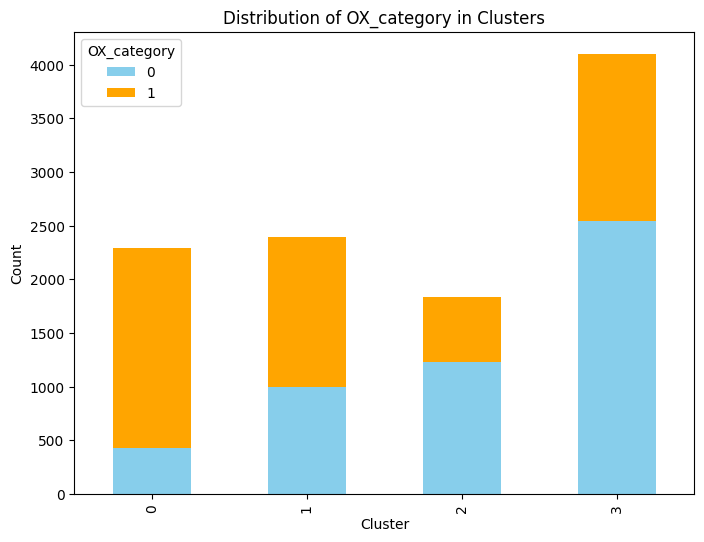

In [351]:
import matplotlib.pyplot as plt

pivot_tablenob = cluster_countsnob.pivot(index='Cluster', columns='OX_category', values='Count')

pivot_tablenob.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'orange'])
plt.title('Distribution of OX_category in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='OX_category', labels=['0', '1'])
plt.show()

Now, we know that we should at least be suspicious of a batch if it is from cluster 0 or 1. 

CONCLUSIONS:

After our work, we have discovered a few insights about the relationship between the intial materials of a metal heat and the oxidation levels of the same heat after tapping. 

First of all, we discovered there is a relationship between the Silicon outliers and unacceptable oxygen levels. However, it is difficult to establish a linear relationship between Silicon values in general and oxygen levels. 

This information could be used by the factory. Maybe minding a little bit more the Silicon composition, the oxygen levels can be reduced. 

Secondly, we found that with the initial values of Copper, Carbon and Silicon, it is possible to predict with around a 75% accuracy if the batch is going to have good or bad oxidation values. This increases slightly when taking into account Phosphorus, and grows to 84% accuracy if we take into account the other 5 metals in the dataset. 

This number, 84%, can probably be bettered with a little bit of work. 

This information could be used to make a tool that could advise engineers of when to send a heat for melting. 

Thirdly, we found that making a distinction between different groups regarding metal composition could be helpful when determining if a batch will be good or not. 

Since there are some clusters that have a very clear distributions, our recommender tool could incorporate and use our clusters. 

There are a number of ways in which the work can be continued, we will just name a few: 

    1. By furtherly trying and tuning models and clusters, this time taking into account all the information in the initial measurements dataframe (all the columns). 
    2. By incorporating new information to our inputs, such as metals added in the process, energy usage, temperature measurements, etc.
    3. By combining clustering and modelling. It could be a good idea to run our models on each of the clusters, and see how well they do. 

